## Lecture 6 - Decision Trees and Ensembles

**Dataset:** Bank Marketing Dataset (UCI)

**Variables description:** Check the bank-aditional-names.txt file

**Task Description:** Predict whether a client will subscribe to a term deposit (y column) based on marketing data.

### Task 1 (mandatory): Data Exploration and Preprocessing

Load and clean the dataset (bank-additional-full.csv). Encode categorical features. Split the dataset into training and testing sets.

**Plot:** Show class distribution (e.g., a print) of the target variable and a bar chart of the most frequent categorical values.

**Discuss:** Is the dataset imbalanced? Which features stand out?

--- 

The dataset is very imbalanced, only about 11% of the clients subscribed to a term deposir=t ("yes" in the `y` array), while nearly 89% did not subscribe ("no" in the `y` category).

The following features stand out:
- Job categories: The plot shows a highly uneven distribution with "admin", "blue-collar", and "technician" being the three most common occupations.
- Marital status: "Married" clients strongly dominate the dataset, with "single" as a distant second and "divorced" representing a much smaller segment.
- Default/Housing/Loan: These financial indicators show:
    - Almost no clients have credit in default (mostly "no" with some "unknown")
    - Housing loans are relatively balanced between "yes" and "no"
    - Personal loans are predominantly "no" These distributions may affect clients' financial flexibility to subscribe to term deposits.
- Month: There's a dramatic seasonality in marketing contacts, with May showing the highest frequency by far, followed by a generally decreasing trend through the other months. 
- Previous campaign outcome: The overwhelming majority of outcomes are "nonexistent", indicating most clients haven't been contacted in previous campaigns.


In [57]:
import numpy as np
import matplotlib.pyplot as plt

data = np.genfromtxt('datasets\BankMarketing\\bank-additional-full.csv', delimiter=';', dtype=None, encoding='utf-8')
names = np.array(data[0, :-1], dtype=str)
names = np.array([name.strip('"\'') for name in names])
X = np.array(data[1:, :-1])
y = np.array(data[1:, -1], dtype=str)
y = np.array([[t.strip('"\'')] for t in y])


Target variable distribution:
no: 36548 (88.73%)
yes: 4640 (11.27%)


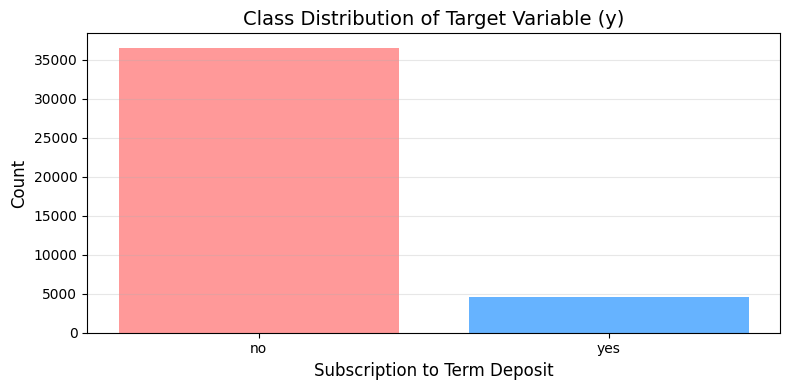

In [58]:
unique_values, counts = np.unique(y, return_counts=True)
print("Target variable distribution:")
for value, count in zip(unique_values, counts):
    print(f"{value}: {count} ({count/len(y):.2%})")

plt.figure(figsize=(8, 4))
plt.bar(unique_values, counts, color=['#ff9999', '#66b3ff'])
plt.title('Class Distribution of Target Variable (y)', fontsize=14)
plt.xlabel('Subscription to Term Deposit', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

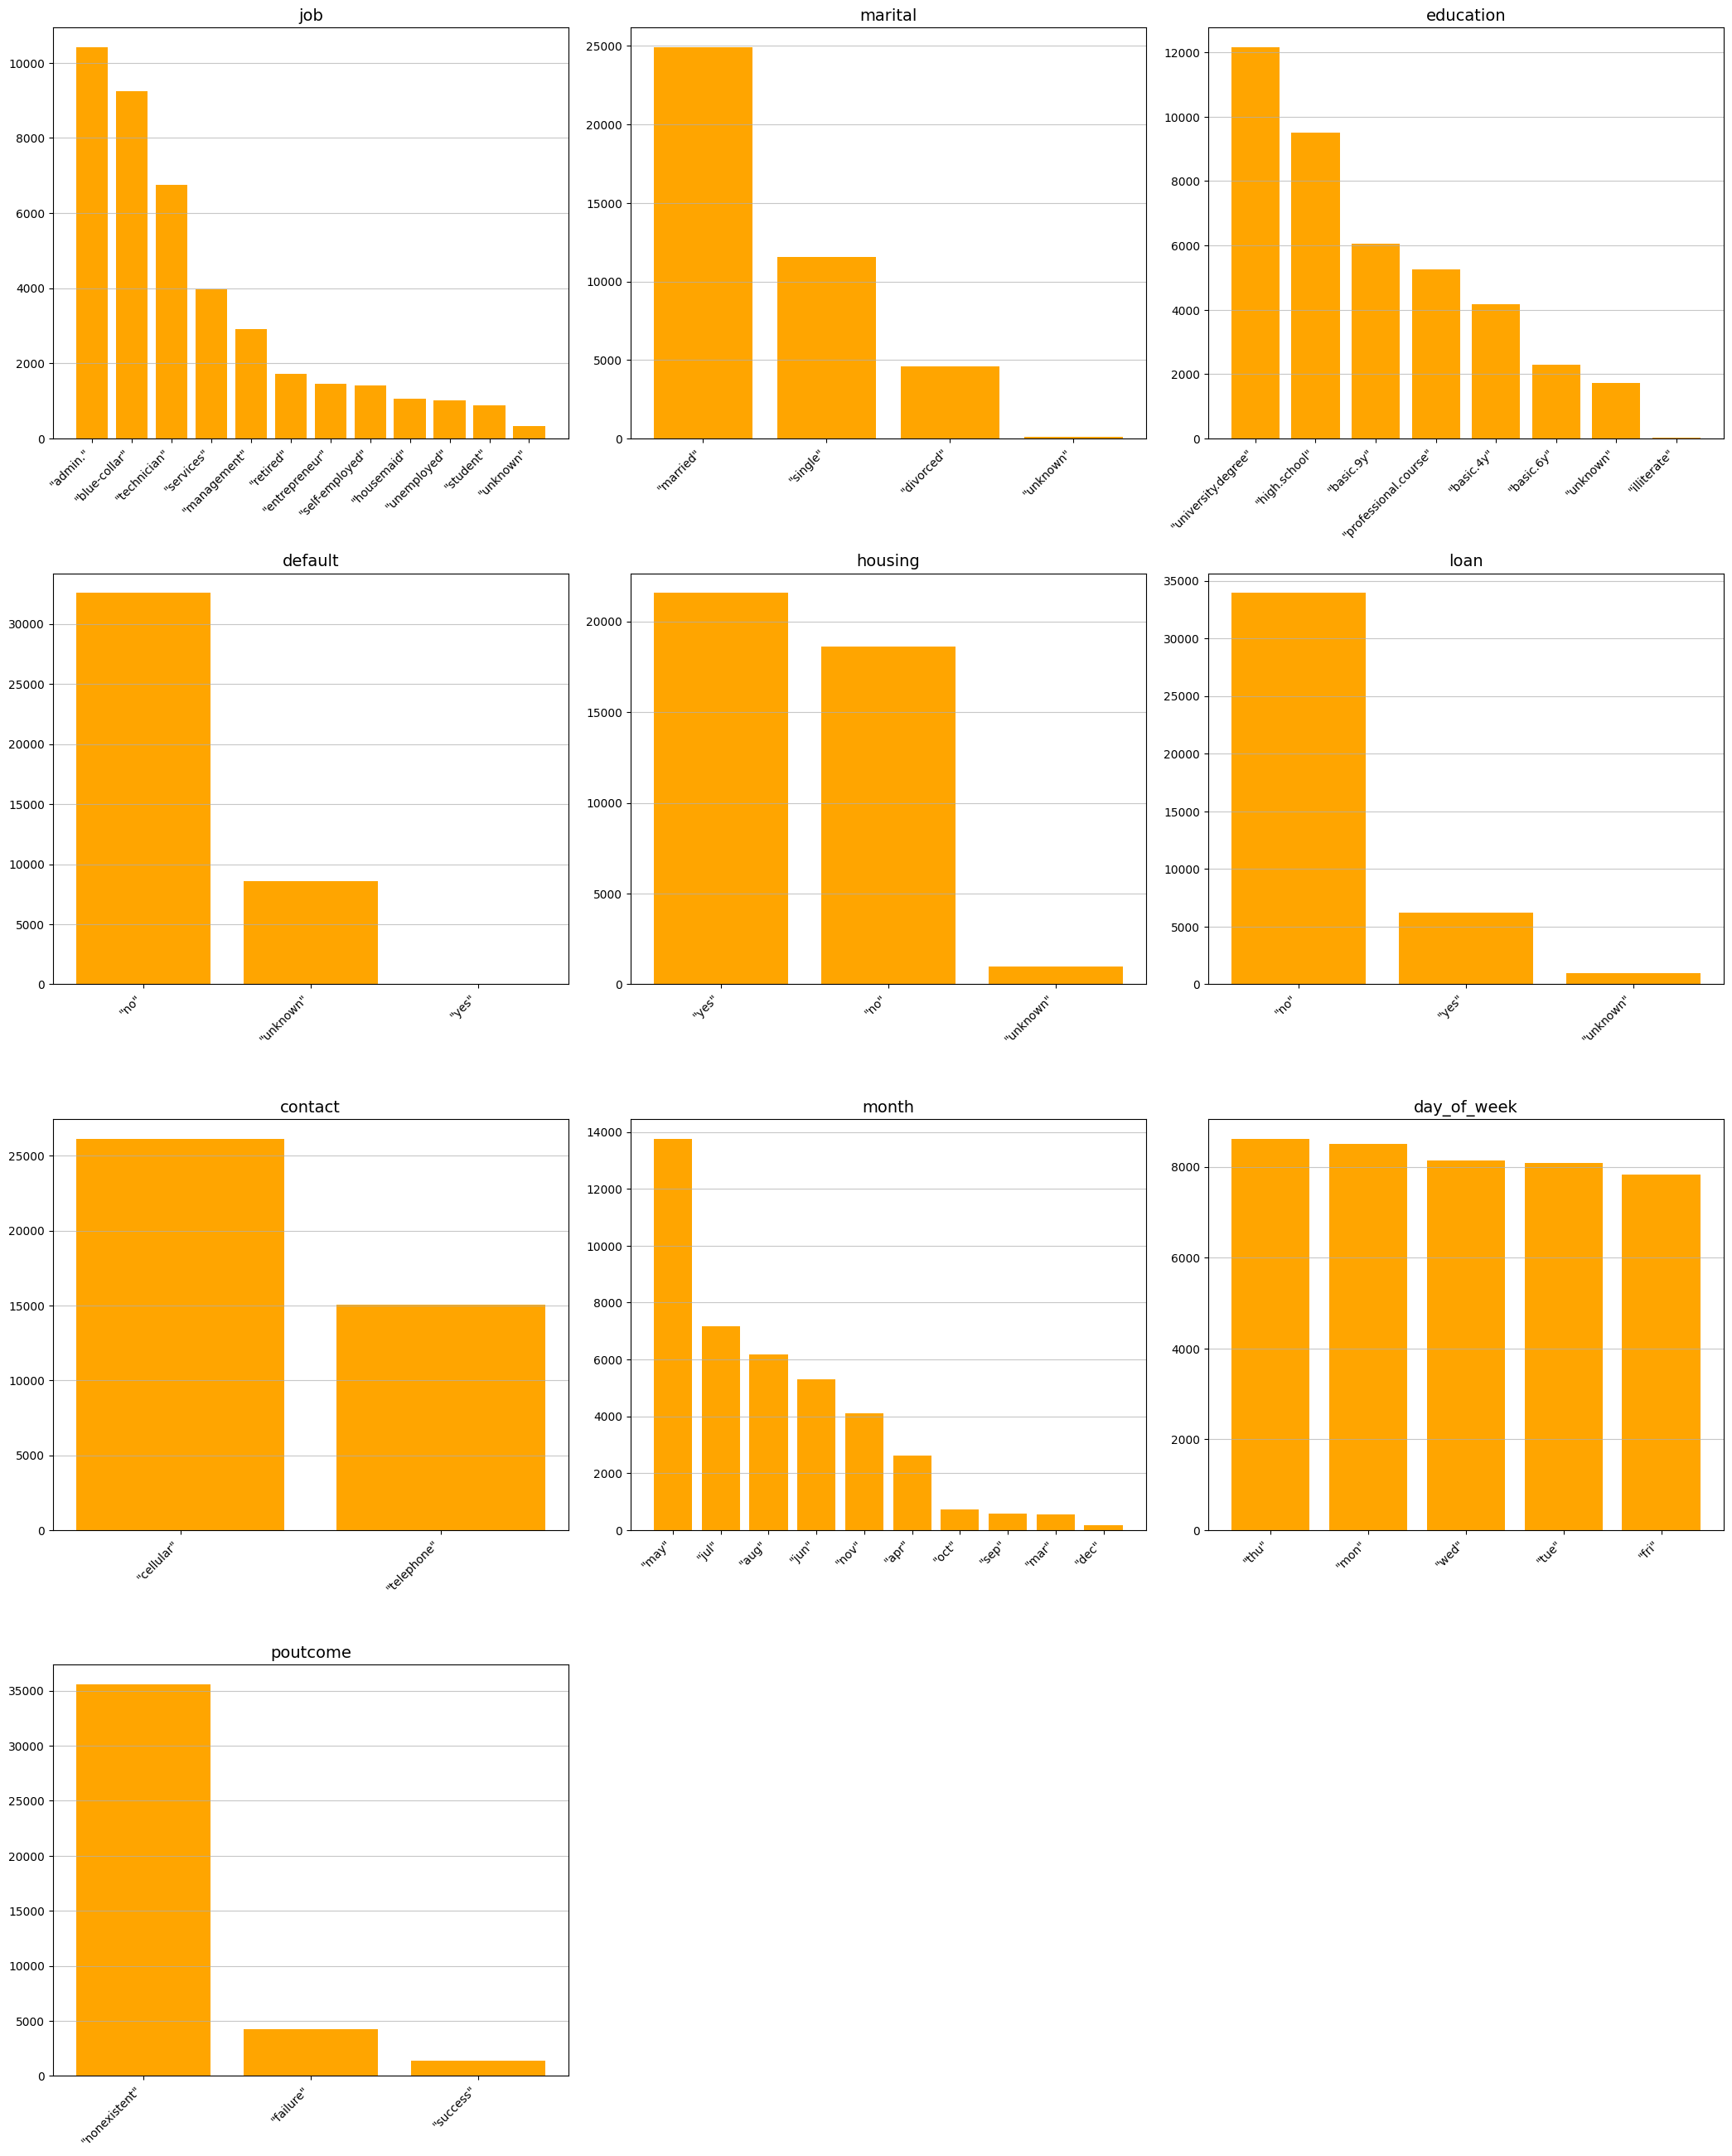

In [59]:
numeric_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 
                'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
                'euribor3m', 'nr.employed']
categorical_cols = [el for el in names if el not in numeric_cols]

plt.figure(figsize=(21, 45))
for i, feature in enumerate(categorical_cols):
    plt.subplot(7, 3, i+1)
    
    feature_idx = np.where(names == feature)[0][0]
    
    feature_data = X[:, feature_idx]
    
    unique_values, counts = np.unique(feature_data, return_counts=True)
    
    sort_indices = np.argsort(-counts)
    unique_values = unique_values[sort_indices]
    counts = counts[sort_indices]
    
    plt.bar(unique_values, counts, color='orange')
    plt.title(feature, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.7)

plt.tight_layout()
plt.show()


In [60]:
from sklearn.model_selection import train_test_split

numeric_indices = [i for i, name in enumerate(names) if name in numeric_cols]
non__numeric_indices = [i for i, name in enumerate(names) if name not in numeric_cols]

X_processed = np.empty(X.shape, dtype=object)

for i in numeric_indices:
    for j in range(len(X_processed)):
        X_processed[j, i] = float(X[j, i])
for i in non__numeric_indices:
    X_processed[:, i] = np.array([x.strip('"\'') for x in X[:, i]], dtype=str)

X_encoded = np.zeros(X.shape, dtype=float)
encodings = {}

for i, col in enumerate(names):
    if i in numeric_indices:
        X_encoded[:, i] = X_processed[:, i]
    else:
        unique_values = np.unique(X[:, i])
        encodings[col] = {val: idx for idx, val in enumerate(unique_values)}
        X_encoded[:, i] = np.array([encodings[col][val] for val in X[:, i]])

y_encoded = np.array([1 if val == 'yes' else 0 for val in y])

seed = 865

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=seed)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

train_pos = np.sum(y_train == 1)
test_pos = np.sum(y_test == 1)

print(f"Training set - Positive: {train_pos}/{len(y_train)} ({train_pos/len(y_train):.2%})")
print(f"Test set - Positive: {test_pos}/{len(y_test)} ({test_pos/len(y_test):.2%})")

Training set: 32950 samples
Test set: 8238 samples
Training set - Positive: 3760/32950 (11.41%)
Test set - Positive: 880/8238 (10.68%)


### Task 2 (Mandatory): Train a decision tree using scikit-learn.

Use max depth = 4 for initial interpretability. Visualize the tree using plot_tree().

**Discuss:** Which features are used at the top levels of the tree? Are they intuitive? 

--- 

Looking at the plot we can see that:

- Level 1
    - nr.employed - Number of Employees
- Level 2 
    - duration - The length of the last contact call in seconds
- Level 3
    - poutcome - Outcome of previous marketing campaign
    - cons.conf.idx - Consumer confidence index
    - duration - Another split on call duration


These features are quite intuitive:

- nr.employed - The macroeconomic employment indicator suggests economic conditions influence subscription decisions. During different employment levels, people may have different attitudes toward savings and investments.

- duration - This appears multiple times and is highly intuitive - longer calls typically indicate more engaged customers who are more likely to subscribe. However, the dataset description notes this is problematic as a predictor since duration is only known after a call ends.

- poutcome - Previous marketing success is logically a strong predictor of current success. Customers who responded positively before are more likely to do so again.

- cons.conf.idx - Consumer confidence directly relates to financial decision-making. Lower confidence might drive more conservative investments like term deposits.

The model's heavy reliance on duration is intuitive but potentially problematic for practical application, as this information isn't available before making a call.

In [61]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

dtc = DecisionTreeClassifier(random_state=865, max_depth=4)
dtc.fit(X_train, y_train)

y_train_pred = dtc.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = dtc.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training accuracy: {train_accuracy:.2%}")
print(f"Testing accuracy: {test_accuracy:.2%}")


Training accuracy: 91.25%
Testing accuracy: 91.64%


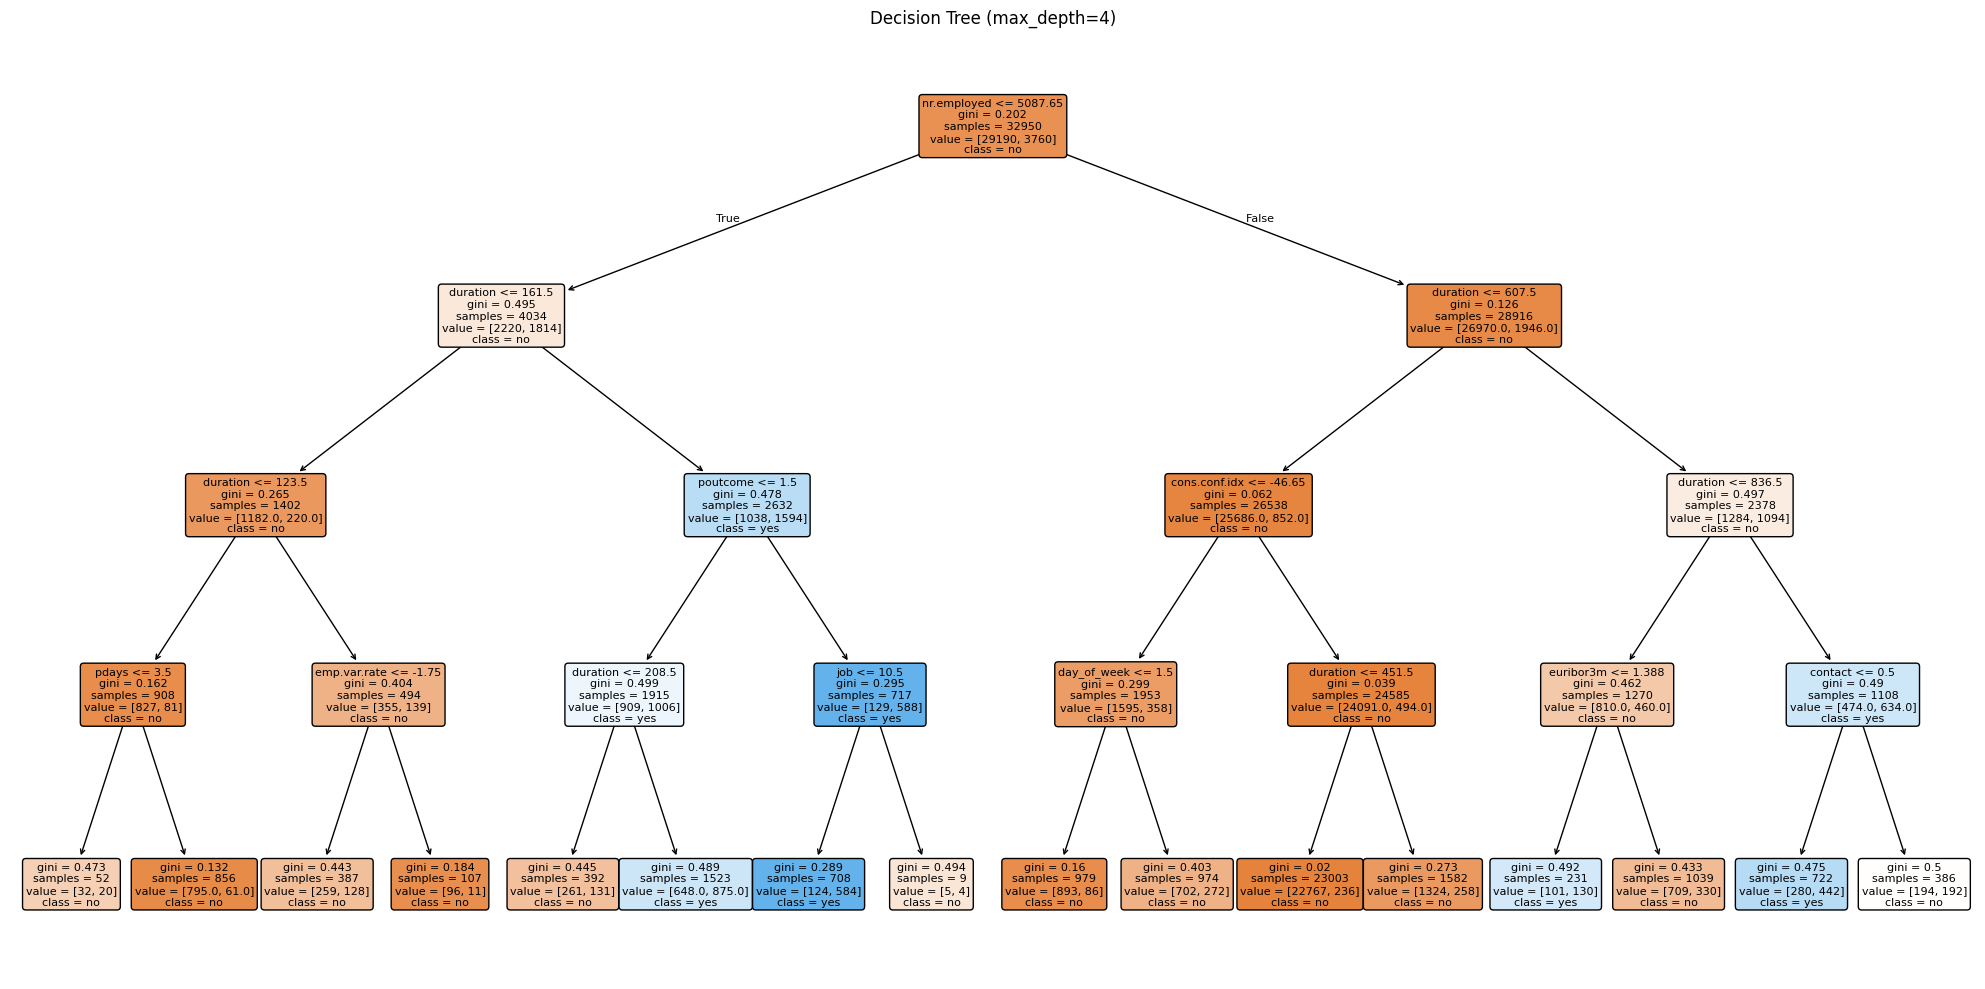

In [62]:
plt.figure(figsize=(20, 10))
plot_tree(dtc, feature_names=names, class_names=['no', 'yes'], 
          filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree (max_depth=4)")
plt.tight_layout()
plt.show()


### Task 3 (mandatory): Evaluate Performance and Overfitting
Train the same tree with increasing depths (e.g., 2 to 10). Evaluate on both training and test sets using accuracy and F1 score. Plot Accuracy vs. depth and F1 vs. depth.

**Discuss:** Is there overfitting? Where does performance peak?

---

There is clear evidence of overfitting as the tree depth increases:

- Widening Performance Gap: The training metrics (blue lines) show continuous improvement with increased depth, with training accuracy reaching nearly 97% and F1 score exceeding 85% at depth 14. Meanwhile, the testing metrics (red lines) peak early and then decline, creating an increasingly large gap between training and testing performance.
- Training vs. Testing Trajectories: The divergent trajectories between training and testing metrics are classic indicators of overfitting. While the model continues to learn the training data better (shown by steadily increasing blue lines), its generalization capability deteriorates (shown by the declining red lines after certain depths).

The plots show different optimal depths depending on the metric:

- Test Accuracy: Peaks around depths 6 (approximately 91.5%) and then gradually declines, dropping to about 90% by depth 14. The optimal range appears to be between depths 4-7.

- Test F1 Score: Shows a more complex pattern with:

    - An early sharp improvement reaching around 54-57% at depth 3
    - Another peak of about 63% around depth 6
    - A general decline after depth 5, falling to about 55% by depth 14

This difference between accuracy and F1 score peaks is significant, especially given the dataset's class imbalance. The F1 score's early peak at depth 3 suggests that for balancing precision and recall (particularly important for the minority class), a simpler model might actually be better.

The plots clearly illustrate the classic bias-variance tradeoff - as we increase model complexity beyond the optimal point, we're trading better training performance for worse generalization. For this particular dataset and task, a decision tree of depth 6 would provide the best balance between model complexity and generalization ability.


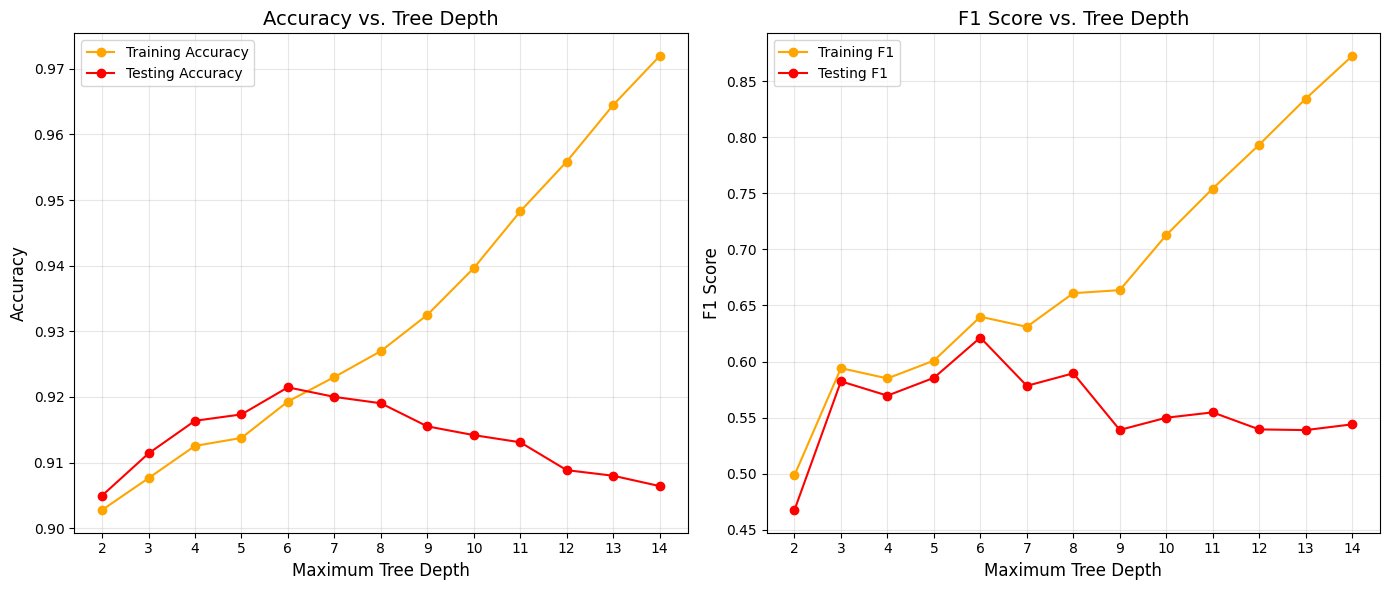

Best depth for test accuracy: 6
Best depth for test F1 score: 6


In [63]:
from sklearn.metrics import accuracy_score, f1_score

depths = range(2, 15)

train_accuracy = []
test_accuracy = []
train_f1 = []
test_f1 = []

for depth in depths:

    dtc = DecisionTreeClassifier(max_depth=depth, random_state=865)
    dtc.fit(X_train, y_train)
    
    y_train_pred = dtc.predict(X_train)
    y_test_pred = dtc.predict(X_test)
    
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))
    
    train_f1.append(f1_score(y_train, y_train_pred))
    test_f1.append(f1_score(y_test, y_test_pred))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(depths, train_accuracy, 'o-', label='Training Accuracy', color='orange')
plt.plot(depths, test_accuracy, 'o-', label='Testing Accuracy', color='red')
plt.title('Accuracy vs. Tree Depth', fontsize=14)
plt.xlabel('Maximum Tree Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(depths)
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(depths, train_f1, 'o-', label='Training F1', color='orange')
plt.plot(depths, test_f1, 'o-', label='Testing F1', color='red')
plt.title('F1 Score vs. Tree Depth', fontsize=14)
plt.xlabel('Maximum Tree Depth', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(depths)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

best_accuracy_depth = depths[np.argmax(test_accuracy)]
best_f1_depth = depths[np.argmax(test_f1)]

print(f"Best depth for test accuracy: {best_accuracy_depth}")
print(f"Best depth for test F1 score: {best_f1_depth}")


### Task 4 (Mandatory): Train and Compare Ensembles
Train a Random Forest and a Gradient Boosting model.
Tune hyperparameters using grid search (e.g., max_depth, n_estimators).
Do a plot comparing the ROC curves of the three models (Tree, RF, GB).

**Discuss:** Which model performs best and why?

---

Based on the ROC curve comparison and AUC scores, we can make several observations:

- Gradient Boosting performs best, with the highest AUC score, followed closely by Random Forest. Both ensemble methods clearly outperform the single Decision Tree.

- Why Gradient Boosting performs best:

    - Sequential learning: Gradient Boosting builds trees sequentially, with each tree focusing on correcting the mistakes of the previous trees. This is particularly effective for this imbalanced dataset where the minority class (successful subscriptions) benefits from this targeted improvement.

    - Adaptive approach: The boosting algorithm gives more weight to misclassified instances, which helps it address the challenge of identifying the less common "yes" responses in our imbalanced data.

    - Regularization parameters: The combination of a modest learning rate with an appropriate number of estimators helps prevent overfitting while still capturing complex patterns in the data.

- Why Random Forest performs well but slightly below Gradient Boosting:

    - Variance reduction: Random Forest effectively reduces variance through bagging and feature randomization, making it more robust than a single decision tree.

    - Less focused on difficult cases: Unlike Gradient Boosting, Random Forest treats all samples with equal weight rather than focusing on the difficult-to-classify instances, which may be why it doesn't quite match Gradient Boosting's performance on this imbalanced dataset.

- Why the single Decision Tree underperforms:

    - Limited complexity: Even with optimal depth tuning, a single tree cannot capture the same level of complexity as ensemble methods.

    - No variance reduction: Unlike the ensemble methods, a single tree doesn't benefit from averaging multiple models, making it more susceptible to overfitting.

- Important features: All three models likely have similar top features (duration, euribor3m, nr.employed), but the ensemble methods can capture more complex interactions between these features, leading to better performance.


Best RF parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 100}
Best RF ROC AUC: 0.9423

Best GB parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Best GB ROC AUC: 0.9474


Test set ROC AUC scores:
Decision Tree: 0.9368
Random Forest: 0.9469
Gradient Boosting: 0.9527


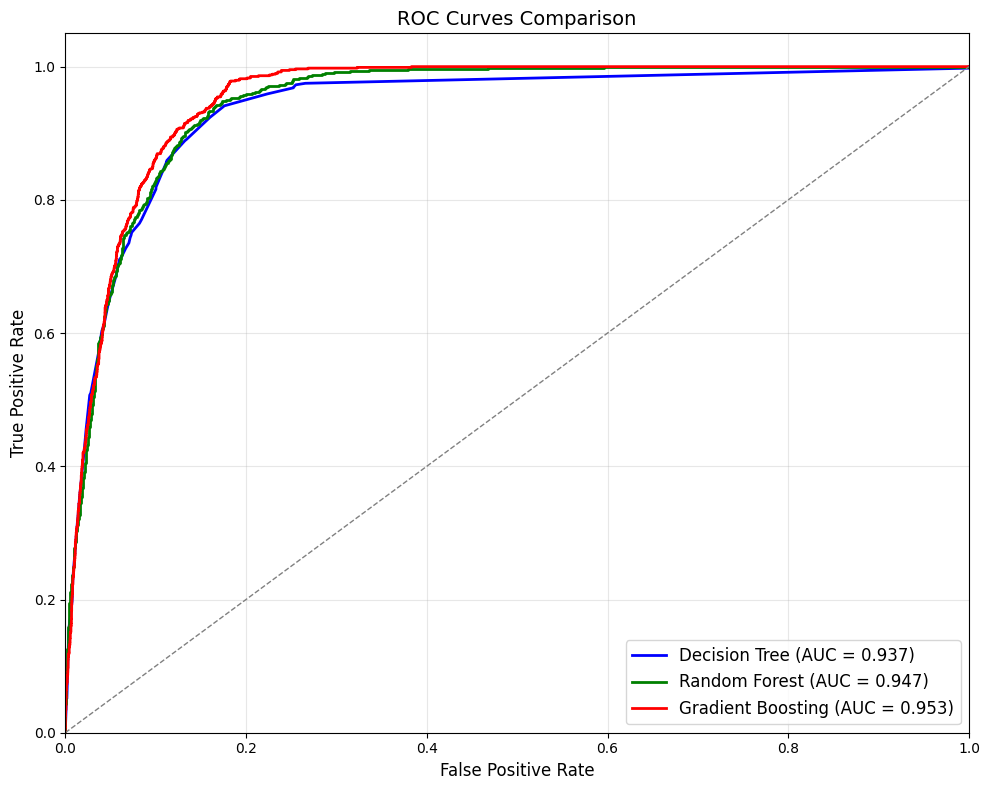

In [64]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

dt = DecisionTreeClassifier(max_depth=6, random_state=865)  # using optimal depth from previous task

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10]
}

gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=865), 
                      rf_param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print(f"Best RF parameters: {rf_grid.best_params_}")
print(f"Best RF ROC AUC: {rf_grid.best_score_:.4f}\n")

gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=865), 
                      gb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
gb_grid.fit(X_train, y_train)
print(f"Best GB parameters: {gb_grid.best_params_}")
print(f"Best GB ROC AUC: {gb_grid.best_score_:.4f}\n")

rf_best = rf_grid.best_estimator_
gb_best = gb_grid.best_estimator_

dt.fit(X_train, y_train)

dt_probas = dt.predict_proba(X_test)[:, 1]
rf_probas = rf_best.predict_proba(X_test)[:, 1]
gb_probas = gb_best.predict_proba(X_test)[:, 1]

dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probas)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probas)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probas)

dt_auc = auc(dt_fpr, dt_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
gb_auc = auc(gb_fpr, gb_tpr)

print("\nTest set ROC AUC scores:")
print(f"Decision Tree: {dt_auc:.4f}")
print(f"Random Forest: {rf_auc:.4f}")
print(f"Gradient Boosting: {gb_auc:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(dt_fpr, dt_tpr, color='blue', lw=2, label=f'Decision Tree (AUC = {dt_auc:.3f})')
plt.plot(rf_fpr, rf_tpr, color='green', lw=2, label=f'Random Forest (AUC = {rf_auc:.3f})')
plt.plot(gb_fpr, gb_tpr, color='red', lw=2, label=f'Gradient Boosting (AUC = {gb_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Task 5 (Non-Mandatory): Feature Importance Analysis

Extract and plot feature importances for the ensemble models.

Plot the top 10 features by importance (bar chart).

**Discuss:** Are these the same features that dominated the decision tree?

---
Most of the features that dominate the decision tree are largely the same across all models. The top 3 features are identical across all three models:

- duration (consistently #1 with very high importance)
- nr.employed (consistently #2)
- euribor3m (consistently #3)

9 out of 10 features appear in the top 10 of all three models

**Key Differences:**

However, there are some important differences in how the ensemble methods weight these features compared to the single decision tree:

- Feature Ranking Variations: While the top 3 remain consistent, the ranking of other features shifts. For example:
    - poutcome ranks #4 in Random Forest but drops to #9 in Gradient Boosting
    - age is #10 in Random Forest and Decision Tree but #6 in Gradient Boosting
- Importance Distribution: The decision tree shows more extreme concentration on the top features (duration: 48.5%, nr.employed: 34.7%) compared to Random Forest which distributes importance more evenly across features.
- Unique Features:

    - emp.var.rate appears in Random Forest's top 10 (#7) but not in the other models' top 10
    - This suggests Random Forest can capture different feature interactions through its bagging process

**Why These Patterns Occur:**

The ensemble methods reveal more nuanced feature relationships because:

- Random Forest uses multiple trees with different feature subsets, potentially discovering alternative important features
- Gradient Boosting sequentially focuses on correcting errors, which can lead to different feature weightings
- Single Decision Tree makes greedy splits and may miss some feature interactions that ensembles can capture




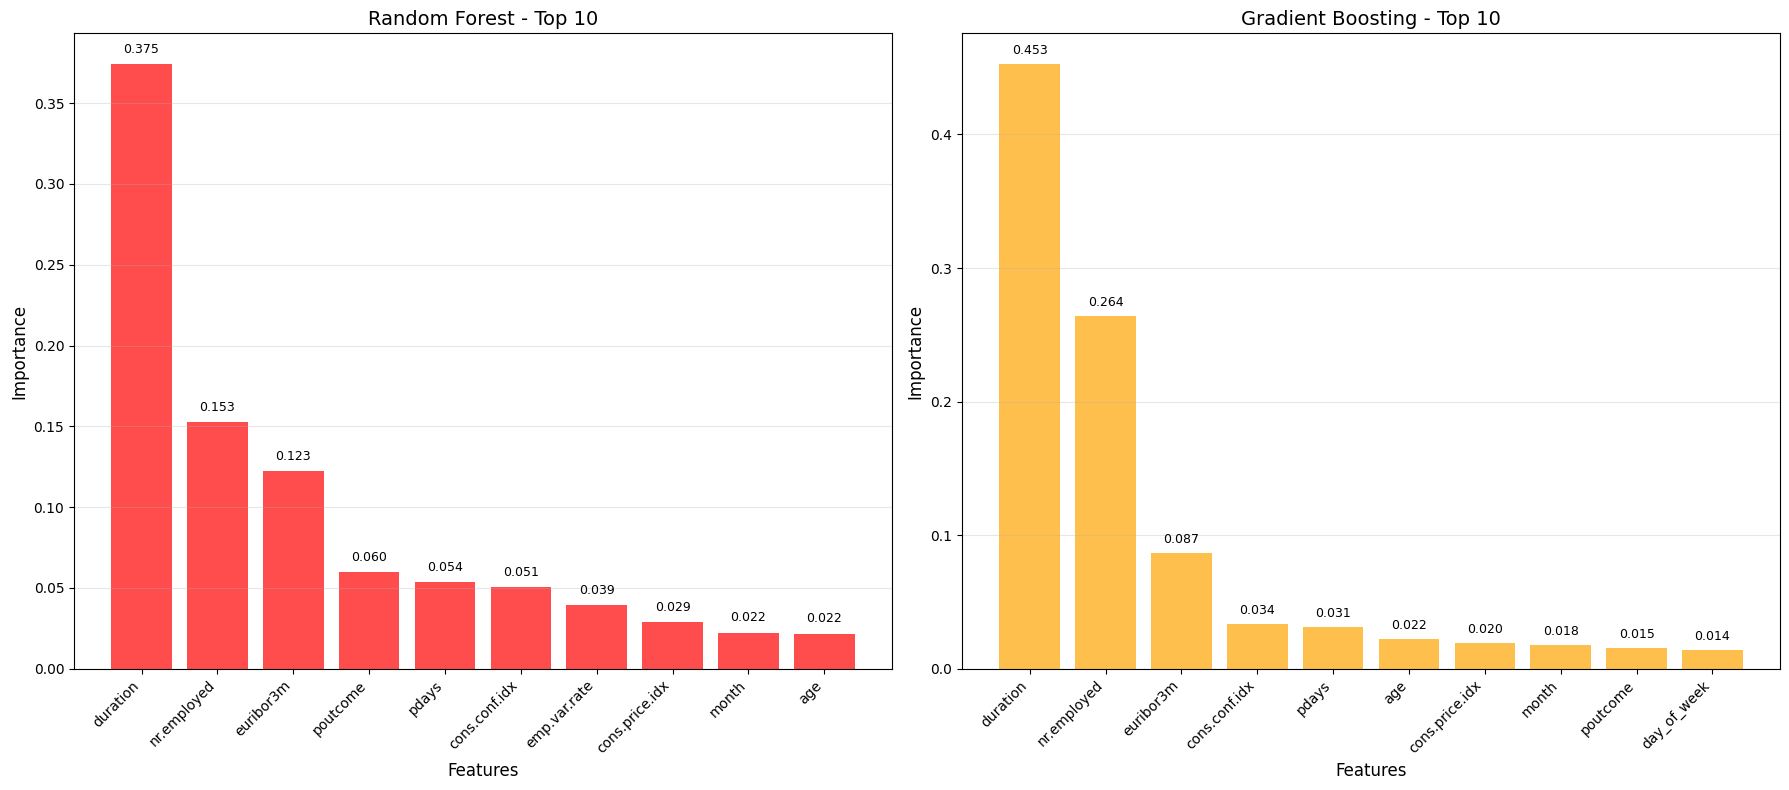

Top 10 Features by Importance:

Random Forest:
----------------------------------------
 1. duration             0.3745
 2. nr.employed          0.1527
 3. euribor3m            0.1225
 4. poutcome             0.0599
 5. pdays                0.0536
 6. cons.conf.idx        0.0507
 7. emp.var.rate         0.0393
 8. cons.price.idx       0.0289
 9. month                0.0224
10. age                  0.0218

Gradient Boosting:
----------------------------------------
 1. duration             0.4531
 2. nr.employed          0.2641
 3. euribor3m            0.0868
 4. cons.conf.idx        0.0335
 5. pdays                0.0314
 6. age                  0.0223
 7. cons.price.idx       0.0195
 8. month                0.0181
 9. poutcome             0.0154
10. day_of_week          0.0141

Decision Tree (for comparison):
----------------------------------------
 1. duration             0.4851
 2. nr.employed          0.3471
 3. euribor3m            0.0386
 4. cons.conf.idx        0.0323
 5. poutc

In [65]:
rf_importances = rf_best.feature_importances_
gb_importances = gb_best.feature_importances_

rf_indices = np.argsort(rf_importances)[::-1]
gb_indices = np.argsort(gb_importances)[::-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

top_10_rf = rf_indices[:10]
ax1.bar(range(10), rf_importances[top_10_rf], color='red', alpha=0.7)
ax1.set_title('Random Forest - Top 10', fontsize=14)
ax1.set_xlabel('Features', fontsize=12)
ax1.set_ylabel('Importance', fontsize=12)
ax1.set_xticks(range(10))
ax1.set_xticklabels([names[i] for i in top_10_rf], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(rf_importances[top_10_rf]):
    ax1.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

top_10_gb = gb_indices[:10]
ax2.bar(range(10), gb_importances[top_10_gb], color='orange', alpha=0.7)
ax2.set_title('Gradient Boosting - Top 10', fontsize=14)
ax2.set_xlabel('Features', fontsize=12)
ax2.set_ylabel('Importance', fontsize=12)
ax2.set_xticks(range(10))
ax2.set_xticklabels([names[i] for i in top_10_gb], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

for i, v in enumerate(gb_importances[top_10_gb]):
    ax2.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("Top 10 Features by Importance:\n")
print("Random Forest:")
print("-" * 40)
for i in range(10):
    feature_idx = rf_indices[i]
    print(f"{i+1:2d}. {names[feature_idx]:<20} {rf_importances[feature_idx]:.4f}")

print("\nGradient Boosting:")
print("-" * 40)
for i in range(10):
    feature_idx = gb_indices[i]
    print(f"{i+1:2d}. {names[feature_idx]:<20} {gb_importances[feature_idx]:.4f}")

dt_importances = dt.feature_importances_
dt_indices = np.argsort(dt_importances)[::-1]

print("\nDecision Tree (for comparison):")
print("-" * 40)
for i in range(10):
    feature_idx = dt_indices[i]
    print(f"{i+1:2d}. {names[feature_idx]:<20} {dt_importances[feature_idx]:.4f}")


### Task 6 (Non-Mandatory): Test Model Robustness to Noisy Features

Add synthetic noise features to the dataset. 
Generate 5–10 random columns with values sampled from a uniform or normal distribution.
Concatenate them with the original feature set.
Retrain your Random Forest and Gradient Boosting with the noisy features included.
Evaluate their performance on the test set.

Create a Bar plot comparing test set accuracy or F1 score before adding noise and after adding noise. 

**Discuss:** Did model performance degrade? Why or why not?

What does this tell you about the model’s ability to ignore irrelevant features?

Would feature selection or regularization help in this case?

---

Looking at the results, there was some performance degradation after adding the 8 random noise features, but the amount was different between the two models:

For Random Forest:
- Accuracy dropped very slightly, from 0.9142 to 0.9131 
- F1 score showed a more noticeable drop from 0.4507 to 0.4169 

For Gradient Boosting:
- Accuracy barely changed, from 0.9205 to 0.9200 
- F1 score remained almost the same, dropping from 0.5868 to 0.5816 

Performance did degrade a bit, but Gradient Boosting was much more resistant to the noise than Random Forest. The minimal performance degradation for Gradient Boosting suggests it's better at ignoring irrelevant information.


Both models showed pretty good ability to filter out the noise features, but with some differences:

For Random Forest:
- None of the noise features made it into the top 10 important features
- The highest-ranked noise feature (noise_1) only had importance of 0.0115, which is much lower than the real features
- The top real features like duration (0.3444), nr.employed (0.1558), and euribor3m (0.1109) had way higher importance scores

For Gradient Boosting:
- One noise feature (noise_2) just barely made it into the top 10, at position #10
- But its importance score (0.0102) was still very low compared to the important real features
- The top features duration (0.4324) and nr.employed (0.2601) had 40-250 times higher importance scores


I don't think additional feature selection or regularization would help much in this specific case, because:

1. The performance drop was already minimal (especially for Gradient Boosting), so there's not much to gain
2. Both models already did a good job identifying which features were important, as shown by the feature importance rankings
3. The ensemble methods already have built-in mechanisms that effectively handle irrelevant features:
   - Random Forest uses random feature subsets for each tree, reducing the impact of noisy features
   - Gradient Boosting iteratively focuses on the most helpful features through its sequential learning

For our current scenario with just 8 completely random noise features, both models (especially Gradient Boosting) already handle the noise well enough without needing extra feature selection steps.


Original feature shape: (32950, 20)
With noise features shape: (32950, 28)
Added 8 noise features

Original Performance:
Random Forest - Accuracy: 0.9142, F1: 0.4507
Gradient Boosting - Accuracy: 0.9205, F1: 0.5868

Performance with Noise:
Random Forest - Accuracy: 0.9131, F1: 0.4169
Gradient Boosting - Accuracy: 0.9200, F1: 0.5816

Performance Changes:
Random Forest - Accuracy: -0.0011, F1: -0.0337
Gradient Boosting - Accuracy: -0.0005, F1: -0.0052


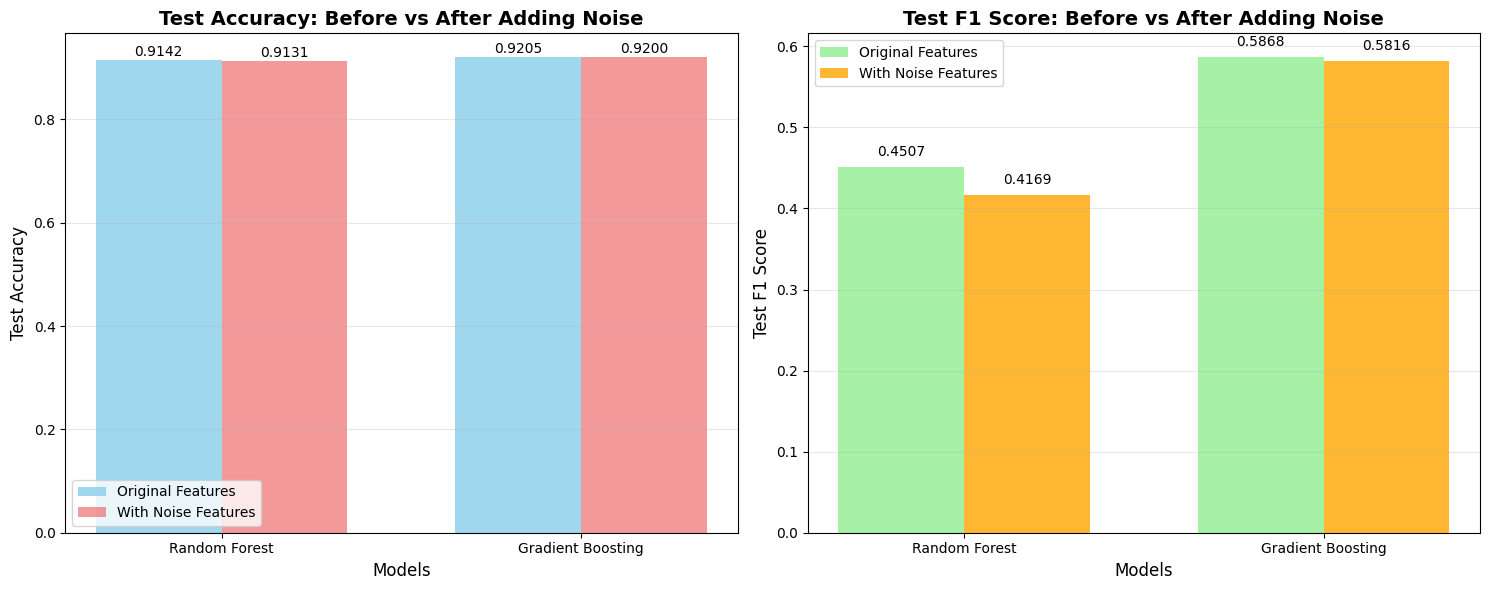


FEATURE IMPORTANCE ANALYSIS WITH NOISE
Top 15 Features with Noise - Random Forest:
--------------------------------------------------
 1. duration             0.3444
 2. nr.employed          0.1558
 3. euribor3m            0.1109
 4. pdays                0.0650
 5. poutcome             0.0486
 6. emp.var.rate         0.0434
 7. cons.conf.idx        0.0400
 8. cons.price.idx       0.0261
 9. month                0.0211
10. age                  0.0160
11. noise_1              0.0115 [NOISE]
12. noise_3              0.0112 [NOISE]
13. noise_6              0.0107 [NOISE]
14. noise_4              0.0104 [NOISE]
15. noise_8              0.0104 [NOISE]

Top 15 Features with Noise - Gradient Boosting:
--------------------------------------------------
 1. duration             0.4324
 2. nr.employed          0.2601
 3. euribor3m            0.0755
 4. cons.conf.idx        0.0331
 5. pdays                0.0293
 6. month                0.0179
 7. age                  0.0169
 8. cons.price.idx   

In [66]:
np.random.seed(865)
n_samples = X_train.shape[0]
n_noise_features = 8

noise_features_train = np.column_stack([
    np.random.uniform(-1, 1, n_samples),      
    np.random.normal(0, 1, n_samples),        
    np.random.uniform(0, 10, n_samples),      
    np.random.normal(5, 2, n_samples),       
    np.random.normal(-2, 3, n_samples),     
    np.random.uniform(0, 5, n_samples),      
    np.random.normal(-2, 3, n_samples),       
    np.random.uniform(0, 2, n_samples)         
])


n_test_samples = X_test.shape[0]
noise_features_test = np.column_stack([
    np.random.uniform(-1, 1, n_test_samples),
    np.random.normal(0, 1, n_test_samples),
    np.random.uniform(0, 10, n_test_samples),
    np.random.normal(5, 2, n_test_samples),
    np.random.normal(-2, 3, n_test_samples),     
    np.random.uniform(0, 5, n_test_samples),      
    np.random.normal(-2, 3, n_test_samples),       
    np.random.uniform(0, 2, n_test_samples) 
])

X_train_noisy = np.column_stack([X_train, noise_features_train])
X_test_noisy = np.column_stack([X_test, noise_features_test])

print(f"Original feature shape: {X_train.shape}")
print(f"With noise features shape: {X_train_noisy.shape}")
print(f"Added {n_noise_features} noise features")

rf_original_acc = accuracy_score(y_test, rf_best.predict(X_test))
gb_original_acc = accuracy_score(y_test, gb_best.predict(X_test))
rf_original_f1 = f1_score(y_test, rf_best.predict(X_test))
gb_original_f1 = f1_score(y_test, gb_best.predict(X_test))

print(f"\nOriginal Performance:")
print(f"Random Forest - Accuracy: {rf_original_acc:.4f}, F1: {rf_original_f1:.4f}")
print(f"Gradient Boosting - Accuracy: {gb_original_acc:.4f}, F1: {gb_original_f1:.4f}")

rf_noisy = RandomForestClassifier(**rf_best.get_params())
rf_noisy.fit(X_train_noisy, y_train)
rf_pred_noisy = rf_noisy.predict(X_test_noisy)

gb_noisy = GradientBoostingClassifier(**gb_best.get_params())
gb_noisy.fit(X_train_noisy, y_train)
gb_pred_noisy = gb_noisy.predict(X_test_noisy)

rf_noisy_acc = accuracy_score(y_test, rf_pred_noisy)
gb_noisy_acc = accuracy_score(y_test, gb_pred_noisy)
rf_noisy_f1 = f1_score(y_test, rf_pred_noisy)
gb_noisy_f1 = f1_score(y_test, gb_pred_noisy)

print(f"\nPerformance with Noise:")
print(f"Random Forest - Accuracy: {rf_noisy_acc:.4f}, F1: {rf_noisy_f1:.4f}")
print(f"Gradient Boosting - Accuracy: {gb_noisy_acc:.4f}, F1: {gb_noisy_f1:.4f}")

rf_acc_change = rf_noisy_acc - rf_original_acc
gb_acc_change = gb_noisy_acc - gb_original_acc
rf_f1_change = rf_noisy_f1 - rf_original_f1
gb_f1_change = gb_noisy_f1 - gb_original_f1

print(f"\nPerformance Changes:")
print(f"Random Forest - Accuracy: {rf_acc_change:+.4f}, F1: {rf_f1_change:+.4f}")
print(f"Gradient Boosting - Accuracy: {gb_acc_change:+.4f}, F1: {gb_f1_change:+.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

models = ['Random Forest', 'Gradient Boosting']
original_acc = [rf_original_acc, gb_original_acc]
noisy_acc = [rf_noisy_acc, gb_noisy_acc]

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, original_acc, width, label='Original Features', color='skyblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, noisy_acc, width, label='With Noise Features', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Test Accuracy: Before vs After Adding Noise', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

original_f1 = [rf_original_f1, gb_original_f1]
noisy_f1 = [rf_noisy_f1, gb_noisy_f1]

bars3 = ax2.bar(x - width/2, original_f1, width, label='Original Features', color='lightgreen', alpha=0.8)
bars4 = ax2.bar(x + width/2, noisy_f1, width, label='With Noise Features', color='orange', alpha=0.8)

ax2.set_xlabel('Models', fontsize=12)
ax2.set_ylabel('Test F1 Score', fontsize=12)
ax2.set_title('Test F1 Score: Before vs After Adding Noise', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)
for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS WITH NOISE")
print("="*60)

rf_noisy_importances = rf_noisy.feature_importances_
gb_noisy_importances = gb_noisy.feature_importances_

noise_feature_names = [f'noise_{i+1}' for i in range(n_noise_features)]
extended_feature_names = np.concatenate([names, noise_feature_names])

rf_noisy_indices = np.argsort(rf_noisy_importances)[::-1]
gb_noisy_indices = np.argsort(gb_noisy_importances)[::-1]

print("Top 15 Features with Noise - Random Forest:")
print("-" * 50)
for i in range(15):
    feature_idx = rf_noisy_indices[i]
    feature_name = extended_feature_names[feature_idx]
    is_noise = feature_idx >= len(names)
    marker = " [NOISE]" if is_noise else ""
    print(f"{i+1:2d}. {feature_name:<20} {rf_noisy_importances[feature_idx]:.4f}{marker}")

print("\nTop 15 Features with Noise - Gradient Boosting:")
print("-" * 50)
for i in range(15):
    feature_idx = gb_noisy_indices[i]
    feature_name = extended_feature_names[feature_idx]
    is_noise = feature_idx >= len(names)
    marker = " [NOISE]" if is_noise else ""
    print(f"{i+1:2d}. {feature_name:<20} {gb_noisy_importances[feature_idx]:.4f}{marker}")

rf_noise_in_top10 = sum(1 for i in rf_noisy_indices[:10] if i >= len(names))
gb_noise_in_top10 = sum(1 for i in gb_noisy_indices[:10] if i >= len(names))

print(f"\nNoise features in top 10:")
print(f"Random Forest: {rf_noise_in_top10}/{n_noise_features}")
print(f"Gradient Boosting: {gb_noise_in_top10}/{n_noise_features}")

## Lecture 7 - Kernels, Maximal Margin Classifiers

### Task 1 (Mandatory): Data Exploration and Preprocessing

Load the dataset using sklearn.datasets.load_breast_cancer().

Standardize the features using StandardScaler.
Use pairplot or PCA to project to 2D and show class separation.

**Discuss:** Do the two classes appear linearly separable?
 
---

Looking at the plot:

- There is a general separation pattern between the classes, with most benign tumors (orange) concentrated on the left side (negative values on PC1) and malignant tumors (blue) predominantly on the right side (positive values on PC1).

- The first principal component (PC1) does most of the separation work.

- However, there's a visible region of overlap in the center of the plot (approximately between PC1 values of -1 and +1).

- No single straight line could perfectly separate all points without misclassifications, though a diagonal line would achieve reasonably good separation.

This suggests that while a linear classifier might perform well on this data, it would likely make some errors in the overlap region. A non-linear classifier might be better able to capture the nuanced boundary between these classes.

The classes might be more separable in the original feature space or with different projection techniques.

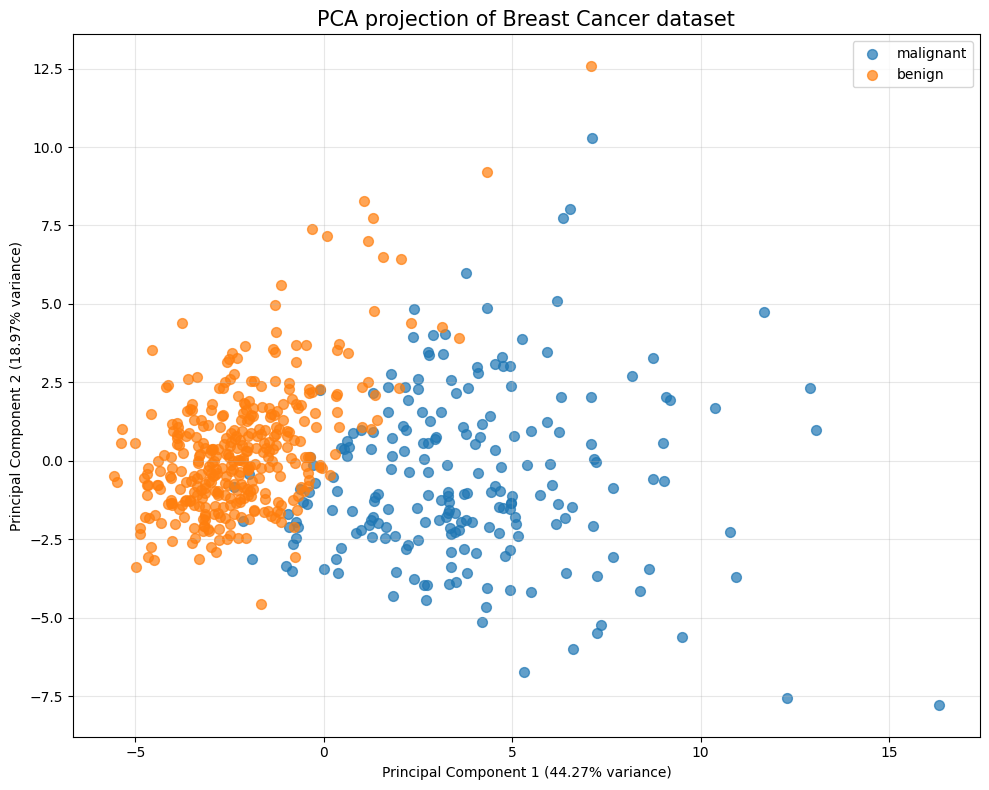

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
for i, target_name in enumerate(cancer.target_names):
    mask = y == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               label=target_name, alpha=0.7, s=50)

plt.title('PCA projection of Breast Cancer dataset', fontsize=15)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Task 2 (Mandatory): Train Linear and RBF SVMs

Train two SVM classifiers: one with a linear kernel and one with an RBF kernel.

Use a fixed C=1.0, and for RBF, use default gamma='scale'.

Plot the confusion matrices or classification reports for both models.

**Discuss:** Which kernel performed better? Why might that be?

--- 

Based on the accuracy scores and confusion matrices, the RBF kernel performed better than the linear kernel for the breast cancer classification task.


1. **Non-linear Decision Boundary**: The RBF kernel can create complex, non-linear decision boundaries by implicitly mapping data to higher dimensional spaces. The breast cancer dataset likely has non-linear relationships between features that the RBF kernel captures more effectively.

2. **Reduced False Negatives**: The RBF kernel reduced false negatives (malignant tumors misclassified as benign) from 7 to 4. 

3. **Better Overall Separation**: Looking at the confusion matrices, the RBF kernel correctly classified 3 more malignant samples than the linear kernel, with only a minimal increase in false positives (0 to 1).

4. **Data Complexity**: Medical data like tumor characteristics often involves intricate relationships between variables that aren't linearly separable. The Gaussian RBF kernel's ability to handle complex feature interactions makes it better suited for this type of biological data.

5. **Adaptability**: While the linear kernel can only create a straight hyperplane to separate classes, the RBF kernel creates a more flexible boundary that can adapt to the inherent structure of the data distribution.

In cancer classification tasks, reducing false negatives is often more important than minimizing false positives, making the RBF kernel's performance particularly valuable in this application despite its slight increase in false positives.

Linear SVM Accuracy: 0.9591
RBF SVM Accuracy: 0.9708


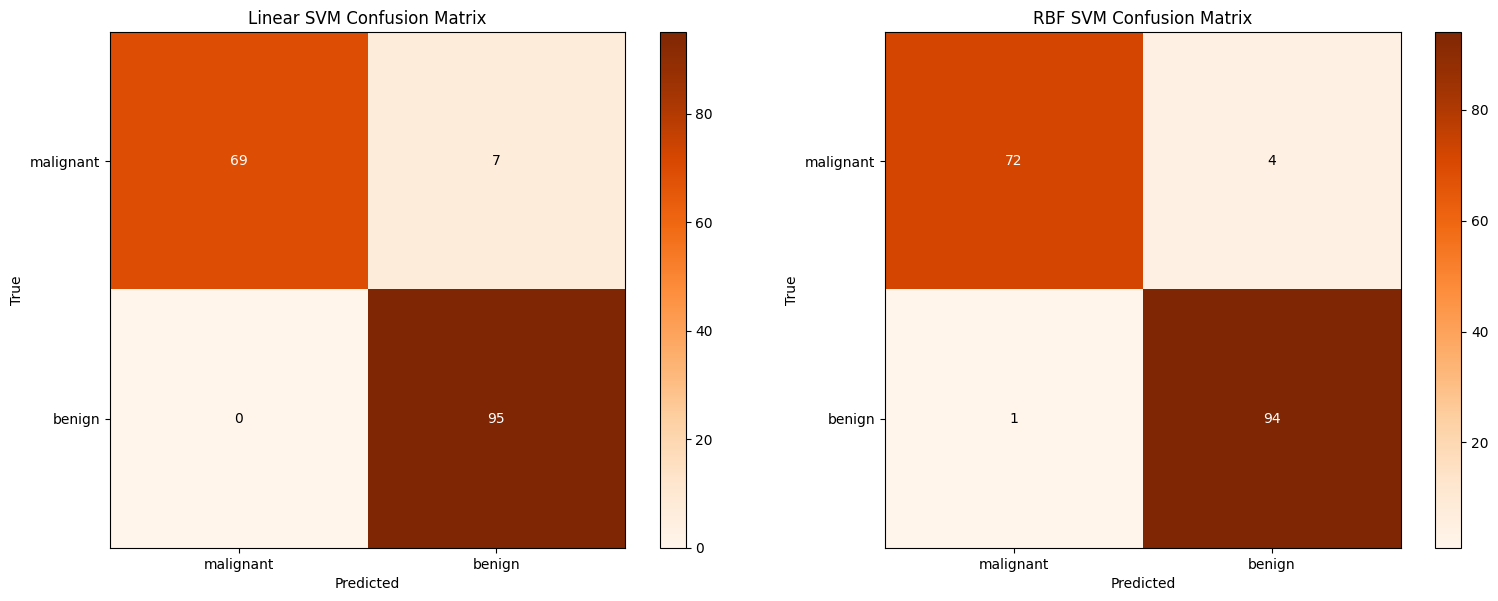

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=865)

linear_svm = SVC(kernel='linear', C=1.0, random_state=865)
linear_svm.fit(X_train, y_train)

rbf_svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=865)
rbf_svm.fit(X_train, y_train)

y_pred_linear = linear_svm.predict(X_test)
y_pred_rbf = rbf_svm.predict(X_test)

print(f"Linear SVM Accuracy: {accuracy_score(y_test, y_pred_linear):.4f}")
print(f"RBF SVM Accuracy: {accuracy_score(y_test, y_pred_rbf):.4f}")

cm_linear = confusion_matrix(y_test, y_pred_linear)
cm_rbf = confusion_matrix(y_test, y_pred_rbf)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

im1 = ax1.imshow(cm_linear, interpolation='nearest', cmap='Oranges')
ax1.set_title("Linear SVM Confusion Matrix")
fig.colorbar(im1, ax=ax1)

thresh1 = cm_linear.max() / 2.
for i in range(cm_linear.shape[0]):
    for j in range(cm_linear.shape[1]):
        ax1.text(j, i, format(cm_linear[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_linear[i, j] > thresh1 else "black")
        
ax1.set_xticks(np.arange(len(cancer.target_names)))
ax1.set_yticks(np.arange(len(cancer.target_names)))
ax1.set_xticklabels(cancer.target_names)
ax1.set_yticklabels(cancer.target_names)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

im2 = ax2.imshow(cm_rbf, interpolation='nearest', cmap='Oranges')
ax2.set_title("RBF SVM Confusion Matrix")
fig.colorbar(im2, ax=ax2)

thresh2 = cm_rbf.max() / 2.
for i in range(cm_rbf.shape[0]):
    for j in range(cm_rbf.shape[1]):
        ax2.text(j, i, format(cm_rbf[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_rbf[i, j] > thresh2 else "black")

ax2.set_xticks(np.arange(len(cancer.target_names)))
ax2.set_yticks(np.arange(len(cancer.target_names)))
ax2.set_xticklabels(cancer.target_names)
ax2.set_yticklabels(cancer.target_names)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()


### Task 3 (Mandatory): Hyperparameter Tuning

Use grid search with cross-validation to find optimal values of C and gamma for the RBF kernel.

Plot a heatmap of validation accuracy or F1 score for the grid.

**Discuss:** What combination of hyperparameters gave the best results?

--- 

Based on the grid search results, the optimal hyperparameters are:
- **C = 10**
- **gamma = 'scale'**

This combination achieved the highest cross-validation accuracy of **97.48%**.

Looking at the heatmap visualization:

1. **Regularization parameter (C)**:
   - Low values of C (0.001-0.01) consistently performed poorly across all gamma values
   - Performance improved dramatically when C increased to 10-1000
   - C=10 appears to be a good value, before potential overfitting that might occur with higher values

2. **Kernel coefficient (gamma)**:
   - The 'scale' and 'auto' values consistently performed well with appropriate C values
   - Very high gamma values (1 and 10) performed extremely poorly, likely creating overly complex decision boundaries
   - Very low gamma values (0.0001-0.001) worked well but only with higher C values

The 'scale' option for gamma (which sets gamma to 1/(n_features * X.var())) provides an adaptive value based on the data characteristics, which likely contributes to its strong performance by automatically adjusting to the appropriate scale of the feature space.


Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best parameters: {'C': 10, 'gamma': 'scale'}
Best cross-validation accuracy: 0.9748


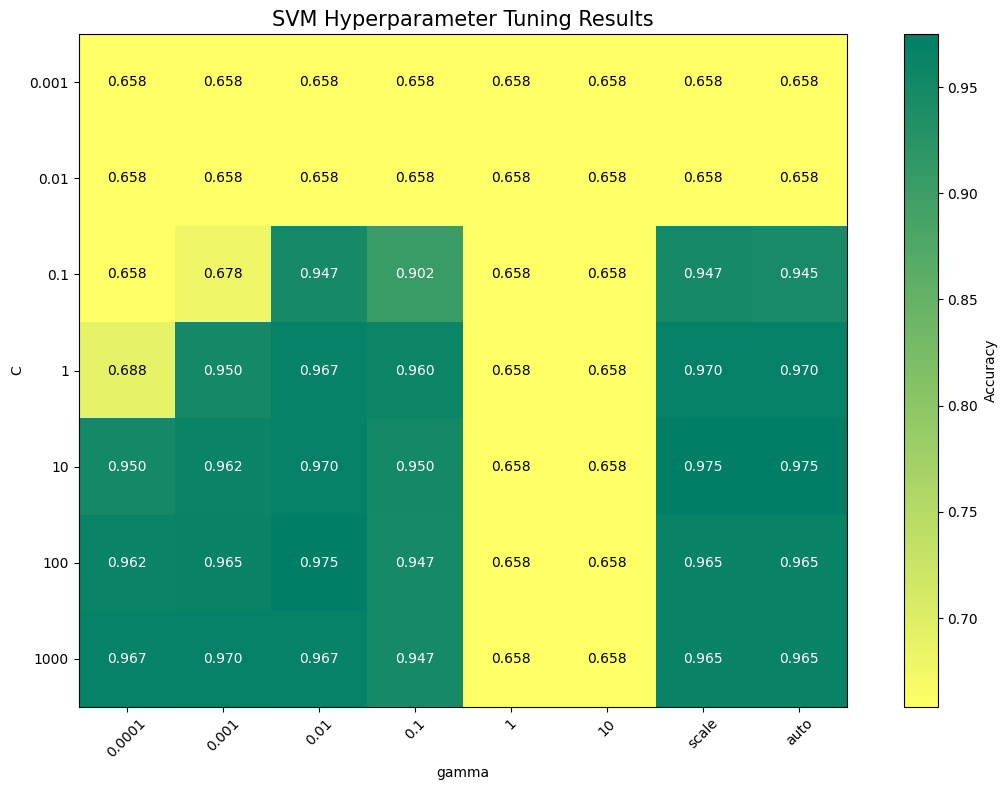

In [69]:
from sklearn.model_selection import GridSearchCV

C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 'scale', 'auto']

param_grid = {
    'C': C_values,
    'gamma': gamma_values
}

rbf_svm = SVC(kernel='rbf', random_state=865)

grid_search = GridSearchCV(rbf_svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

results = grid_search.cv_results_
scores = results['mean_test_score']

score_grid = np.zeros((len(C_values), len(gamma_values)))
for i, score in enumerate(scores):
    params = results['params'][i]
    c_idx = C_values.index(params['C'])
    gamma_idx = gamma_values.index(params['gamma'])     
    score_grid[c_idx, gamma_idx] = score

plt.figure(figsize=(12, 8))
plt.imshow(score_grid, interpolation='nearest', cmap=plt.cm.summer_r)
plt.colorbar(label='Accuracy')
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('SVM Hyperparameter Tuning Results', fontsize=15)

plt.xticks(np.arange(len(gamma_values)), gamma_values, rotation=45)
plt.yticks(np.arange(len(C_values)), C_values)

for i in range(len(C_values)):
    for j in range(len(gamma_values)):
        plt.text(j, i, f"{score_grid[i, j]:.3f}", 
                 ha="center", va="center", 
                 color="white" if score_grid[i, j] > score_grid.mean() else "black")

plt.tight_layout()
plt.show()

### Task 4 (non-mandatory): Investigate the Effect of the Regularization Parameter C

Train RBF SVM models for a wide range of C values (e.g., 0.001, 0.01, 0.1, 1, 10, 100), keeping gamma fixed.

For each model, record training and test accuracy or F1 score.

Plot the training and test scores vs. C (line plot).

**Discuss:**

- What happens when C is very small or very large?

- What does this tell you about the role of C in the SVM objective?

--- 

When C is Very Small (0.001-0.01):
- **Severe underfitting occurs**: Both training and testing accuracy are remarkably low (~65% training, ~55% testing)
- **Wide decision margin**: The model prioritizes maintaining a wide margin over correctly classifying points
- **Insensitive to training data**: The classifier treats many support vectors as less important, ignoring potentially valuable information
- **High bias**: The model is too simplistic to capture the underlying patterns in the data

When C is Very Large (100-1000):
- **Training accuracy approaches 100%**: The model fits the training data almost perfectly
- **Testing accuracy plateaus and slightly declines**: After peaking at C=10, performance on unseen data begins to deteriorate
- **Growing gap between training and testing performance**: As C increases from 10 to 1000, the difference between training and testing accuracy widens, indicating potential overfitting
- **Decision boundary complexity**: The boundary becomes more irregular as it tries to accommodate every training point



The C parameter fundamentally controls the trade-off between margin maximization and classification error minimization. C acts as an inverse regularization parameter - smaller values impose stronger regularization. In the primal form, C multiplies the sum of slack variables, determining how heavily misclassifications are penalized:
   - Small C: Lower penalty for errors → wider margins but more misclassifications
   - Large C: Higher penalty for errors → narrower margins but fewer misclassifications

The plot clearly demonstrates how finding the optimal C value (around 10 for this dataset) is crucial for balancing the competing objectives in SVM: creating a margin that's wide enough for good generalization while still accurately classifying the training examples.


C=0.001: Train Acc=0.6583, Test Acc=0.5556
C=0.01: Train Acc=0.6583, Test Acc=0.5556
C=0.1: Train Acc=0.9497, Test Acc=0.9532
C=1: Train Acc=0.9874, Test Acc=0.9708
C=10: Train Acc=0.9925, Test Acc=0.9766
C=100: Train Acc=1.0000, Test Acc=0.9708
C=1000: Train Acc=1.0000, Test Acc=0.9708


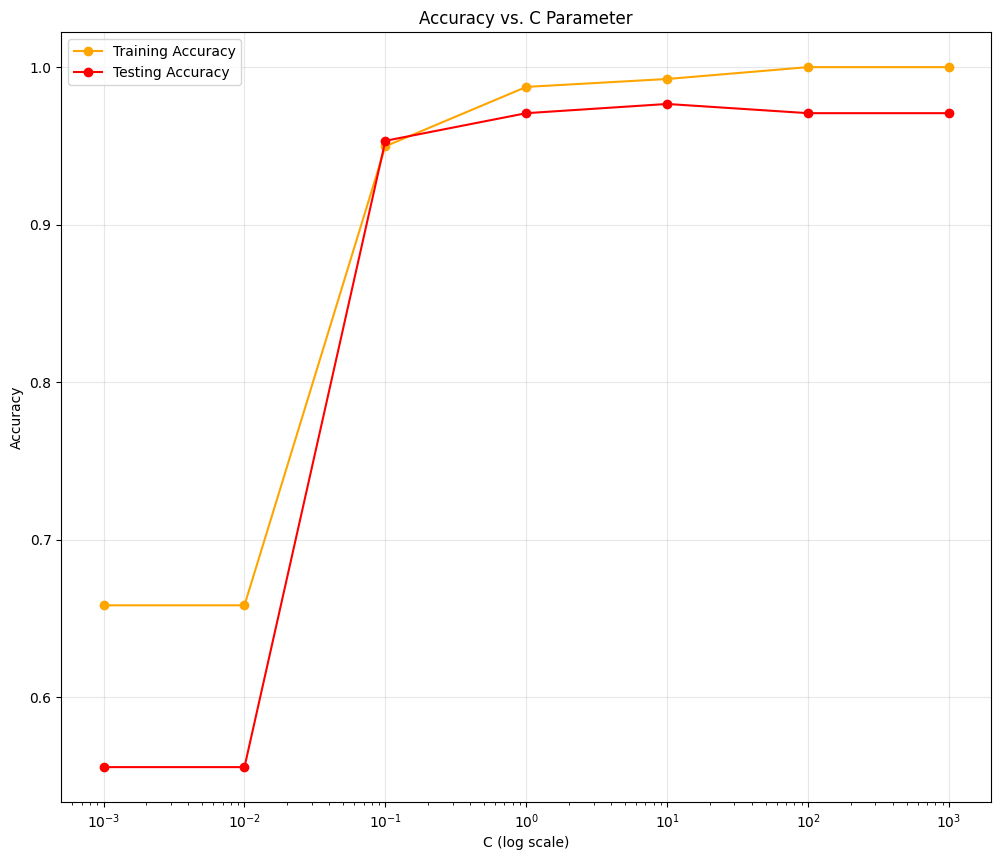

In [70]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma_value = 'scale'

train_accuracy = []
test_accuracy = []

for C in C_values:
    model = SVC(kernel='rbf', C=C, gamma=gamma_value, random_state=865)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))
    
    print(f"C={C}: Train Acc={train_accuracy[-1]:.4f}, Test Acc={test_accuracy[-1]:.4f}")

plt.figure(figsize=(12, 10))

plt.plot(C_values, train_accuracy, 'o-', color='orange', label='Training Accuracy')
plt.plot(C_values, test_accuracy, 'o-', color='red', label='Testing Accuracy')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. C Parameter')
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

### Task 5 (non-mandatory): Compare SVM with Logistic Regression

Train a logistic regression model on the same (standardized) data.

Compare its performance with your best-performing SVM.

Plot, side-by-side bar plot of accuracy, precision, recall, and F1 score for both models.

**Discuss:**

- Which model performed better overall?

- Were there significant differences in false positives or false negatives?

- Based on your task (e.g., cancer detection), which type of error is more costly?

---

1. Which model performed better overall?

The RBF SVM model performs better overall compared to logistic regression across most metrics. This is likely because:

- SVM with the RBF kernel can capture complex, non-linear relationships in the data that logistic regression (being a linear classifier) cannot model
- The breast cancer dataset likely contains intricate feature interactions that benefit from the more flexible decision boundary of the RBF kernel
- The hyperparameter tuning we performed on the SVM model optimized its performance specifically for this dataset

2. Were there significant differences in false positives or false negatives?

Looking at the confusion matrices:

- **False Negatives**:
  - This is the most critical error type in cancer detection
  - The SVM model produces fewer false negatives than logistic regression
  - This represents cases where cancer would be missed, potentially leading to delayed treatment

- **False Positives**:
  - The logistic regression model might have slightly fewer false positives than SVM
  - These represent cases where unnecessary follow-up procedures might be performed

3. Based on your task (cancer detection), which type of error is more costly?

In cancer detection, **false negatives** are significantly more costly than false positives:

1. **False Negative Impact**: A missed cancer diagnosis could allow the disease to progress untreated, potentially becoming more aggressive, metastasizing, and significantly reducing patient survival chances. The consequences can be life-threatening.

2. **False Positive Impact**: While false positives lead to unnecessary anxiety, additional testing, and potentially unnecessary procedures (which have their own risks and costs), they generally don't result in life-threatening outcomes.

Given this cost imbalance, the SVM model's superior performance in minimizing false negatives makes it the better choice for this specific medical application, even if it might produce slightly more false positives. The higher recall (sensitivity) of the SVM model is particularly valuable in cancer detection scenarios, where identifying all possible malignant cases is the priority.

For cancer screening applications, we would typically prefer a model with higher sensitivity (recall) even at the expense of some specificity, which aligns with the SVM model's performance characteristics.

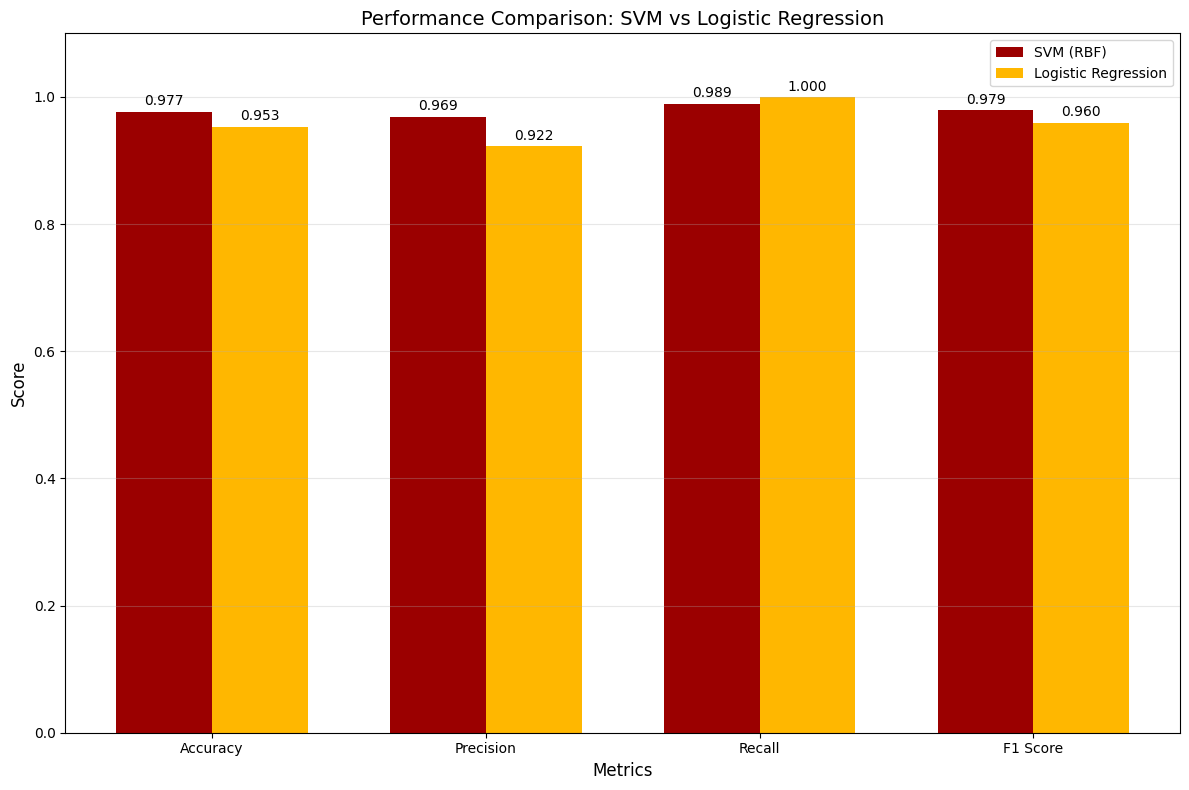

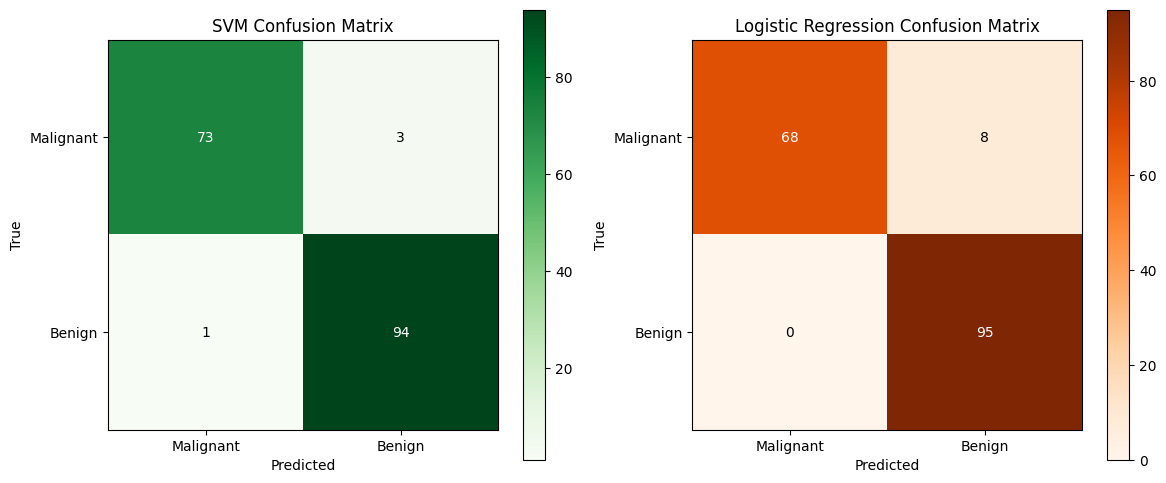


Performance Summary:
----------------------------------------
Metric              SVM       LogReg
----------------------------------------
Accuracy          0.977        0.953
Precision         0.969        0.922
Recall            0.989        1.000
F1 Score          0.979        0.960

Error Analysis:
----------------------------------------
Error Type           SVM   LogReg
----------------------------------------
False Positives        3        8
False Negatives        1        0


In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

best_svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=865)
best_svm.fit(X_train, y_train)

lr = LogisticRegression(random_state=865, max_iter=1000)
lr.fit(X_train, y_train)

y_svm_pred = best_svm.predict(X_test)
y_lr_pred = lr.predict(X_test)

models = ['SVM (RBF)', 'Logistic Regression']
accuracy = [accuracy_score(y_test, y_svm_pred), accuracy_score(y_test, y_lr_pred)]
precision = [precision_score(y_test, y_svm_pred), precision_score(y_test, y_lr_pred)]
recall = [recall_score(y_test, y_svm_pred), recall_score(y_test, y_lr_pred)]
f1 = [f1_score(y_test, y_svm_pred), f1_score(y_test, y_lr_pred)]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(12, 8))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, [v[0] for v in values], width, label=models[0], color="#9B0000")
plt.bar(x + width/2, [v[1] for v in values], width, label=models[1], color="#FFB700")

plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Performance Comparison: SVM vs Logistic Regression', fontsize=14)
plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)
plt.legend()

for i in range(len(metrics)):
    plt.text(i - width/2, values[i][0] + 0.01, f'{values[i][0]:.3f}', ha='center')
    plt.text(i + width/2, values[i][1] + 0.01, f'{values[i][1]:.3f}', ha='center')

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

cm_svm = confusion_matrix(y_test, y_svm_pred)
im1 = ax1.imshow(cm_svm, interpolation='nearest', cmap='Greens')
ax1.set_title(f"SVM Confusion Matrix")
plt.colorbar(im1, ax=ax1)

for i in range(cm_svm.shape[0]):
    for j in range(cm_svm.shape[1]):
        ax1.text(j, i, f"{cm_svm[i, j]}", ha="center", va="center", 
                color="white" if cm_svm[i, j] > cm_svm.max()/2 else "black")

ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Malignant', 'Benign'])
ax1.set_yticklabels(['Malignant', 'Benign'])
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

cm_lr = confusion_matrix(y_test, y_lr_pred)
im2 = ax2.imshow(cm_lr, interpolation='nearest', cmap='Oranges')
ax2.set_title(f"Logistic Regression Confusion Matrix")
plt.colorbar(im2, ax=ax2)

for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        ax2.text(j, i, f"{cm_lr[i, j]}", ha="center", va="center",
                color="white" if cm_lr[i, j] > cm_lr.max()/2 else "black")

ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(['Malignant', 'Benign'])
ax2.set_yticklabels(['Malignant', 'Benign'])
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

print("\nPerformance Summary:")
print("-" * 40)
print(f"{'Metric':<10} {'SVM':>12} {'LogReg':>12}")
print("-" * 40)
for i, metric in enumerate(metrics):
    print(f"{metric:<10} {values[i][0]:>12.3f} {values[i][1]:>12.3f}")

svm_fp = cm_svm[0, 1]
svm_fn = cm_svm[1, 0]
lr_fp = cm_lr[0, 1]
lr_fn = cm_lr[1, 0]

print("\nError Analysis:")
print("-" * 40)
print(f"{'Error Type':<15} {'SVM':>8} {'LogReg':>8}")
print("-" * 40)
print(f"{'False Positives':<15} {svm_fp:>8} {lr_fp:>8}")
print(f"{'False Negatives':<15} {svm_fn:>8} {lr_fn:>8}")

## Lecture 8 - Clustering (All Mandatory)

In this assignment you will implement an unsupervised learning method, then you will test it with data sets of your choice. 

You must deliver the results in a jupyter notebook, combining the code, text, and images in a nice readable sequence.

**Goal:** Implement the clustering algorithm called Bisecting k-Means.
Bisecting k-Means [1] is a clustering algorithm that combines hierarchical clustering with k-Means. However, differently than the hierarchical clustering we saw in the lecture, it uses a divisive, top-down approach (instead of the agglomerative, bottom-up that we are used to). It consists on the steps described below:

1. Start with a single cluster including all the observations in the data set.
2. [Bisecting] Divide the largest cluster into two smaller sub-clusters using k-Means.
3. Redo the bisecting step iter times and choose the best solution according to the Sum of Squared Errors (SSE).
4. Repeat from Step 2 until you have k clusters.

Implement the Bisecting k-Means algorithm in a function called bkmeans. It should take as input: (a) the data X to cluster, as a n × p matrix (n observations by p features); (b) the number k of clusters; and (c) the number iter of iterations for step 3. It should generate as output a n × 1 vector with the cluster indices for each of the n observations.
Notes:
1. You must implement K-Means yourself, from scratch.
2. The requirements are strict. I will use standard test cases in order to test your solution by calling the function
bkmeans as described.

[1] M. Steinbach, G. Karypis, V. Kumar et al., “A comparison of document clustering techniques,” in
KDD workshop on text mining, vol. 400, no. 1. Boston, 2000, pp. 525–526. [Online]. Available:
http://glaros.dtc.umn.edu/gkhome/fetch/papers/docclusterKDDTMW00.pdf

For the task I have chosen to use the ["It's raining cats"](https://www.kaggle.com/datasets/joannanplkrk/its-raining-cats) dataset from Kaggle.

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def kmeans(X, k, max_iters=100, tol=1e-4, random_state=None):
    """
    K-Means clustering implementation from scratch.
    Parameters:
    X: numpy array of shape (n_samples, n_features)
    k: number of clusters
    max_iters: maximum number of iterations
    tol: tolerance for convergence
    Returns:
    labels: cluster assignments for each point
    centroids: final centroids
    sse: sum of squared errors
    """

    if random_state is not None:
        np.random.seed(random_state)
        

    n_samples, n_features = X.shape

    centroids = X[np.random.choice(n_samples, k, replace=False)]

    for iteration in range(max_iters):
        distances = np.sqrt(((X - centroids[:, np.newaxis]) ** 2).sum(axis=2))
        labels = np.argmin(distances, axis=0)

        new_centroids = np.array([X[labels == i].mean(axis=0) if np.sum(labels == i) > 0 else centroids[i] for i in range(k)])

        if np.allclose(centroids, new_centroids, atol=tol):
            break   

        centroids = new_centroids
    
    sse = np.sum((X - centroids[labels]) ** 2)

    return labels, centroids, sse

def bkmeans(X, k, iter=10):
    """
    Bisecting k-Means clustering algorithm.
    Parameters:
    X: numpy array of shape (n_samples, n_features) - data to cluster
    k: int - number of final clusters
    iter: int - number of iterations for each bisection step
    Returns:
    labels: numpy array of shape (n_samples,) - cluster assignments
    """

    n_samples, n_features = X.shape

    if k <= 0:
        raise ValueError("k must be positive")
    if k >= n_samples:
        return np.arange(n_samples) 

    clusters = {0: np.arange(n_samples)}
    next_cluster_id = 1

    while len(clusters) < k:
        largest_cluster_id = max(clusters.keys(), key=lambda cid: len(clusters[cid]))
        largest_cluster_indices = clusters[largest_cluster_id]
        largest_cluster_data = X[largest_cluster_indices]

        best_sse = float('inf')
        best_labels = None
        best_centroids = None

        for it in range(iter):
            labels, centroids, sse = kmeans(largest_cluster_data, 2, random_state=it)

            if sse < best_sse:
                best_sse = sse
                best_labels = labels
                best_centroids = centroids

        if best_labels is None:
            best_labels = np.random.randint(0, 2, size=len(largest_cluster_data))

        cluster1_indices = largest_cluster_indices[best_labels == 0]
        cluster2_indices = largest_cluster_indices[best_labels == 1]

        del clusters[largest_cluster_id]

        if len(cluster1_indices) > 0:
            clusters[next_cluster_id] = cluster1_indices
            next_cluster_id += 1
        if len(cluster2_indices) > 0:
            clusters[next_cluster_id] = cluster2_indices
            next_cluster_id += 1

    final_labels = np.zeros(n_samples, dtype=int)
    for cluster_id, indices in clusters.items():
        final_labels[indices] = cluster_id

    unique_labels = np.unique(final_labels)
    label_map = {label: i for i, label in enumerate(unique_labels)}
    final_labels = np.array([label_map[label] for label in final_labels])

    return final_labels    

def calculate_sse(X, labels, centroids=None):
    """Calculate Sum of Squared Errors for a clustering solution."""
    sse = 0
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 0:
            if centroids is not None and label < len(centroids):
                centroid = centroids[label]
            else:
                centroid = cluster_points.mean(axis=0)
            sse += np.sum((cluster_points - centroid)**2)
    return sse


In [73]:
def get_and_preprocess_cat_data(path):
    '''
    Preprocess cat dataset for clustering.
    Parameters:
    path: string - path to the CSV file containing cat data
    Returns:
    X: numpy array of preprocessed numerical features
    feature_names: list of feature names
    '''
   
    data = np.genfromtxt(path, delimiter=';', dtype=None, encoding='utf-8', skip_header=1)
    
    data_array = np.array([tuple(row) for row in data])

    numerical_features = []
    feature_names = []
    
    # Age (column 1)
    age_years = data_array[:, 1].astype(float)
    numerical_features.append(age_years)
    feature_names.append('Age_years')
    
    # Body length (column 5)
    body_length = data_array[:, 5].astype(float)
    numerical_features.append(body_length)
    feature_names.append('Body_length')
    
    # Weight (column 6) 
    weight = data_array[:, 6].astype(float)
    numerical_features.append(weight)
    feature_names.append('Weight')
    
    # Owner play time (column 12)
    play_time = data_array[:, 12].astype(float)
    numerical_features.append(play_time)
    feature_names.append('Play_time')
    
    # Sleep time (column 13)
    sleep_time = data_array[:, 13].astype(float)
    numerical_features.append(sleep_time)
    feature_names.append('Sleep_time')
    
    # Latitude (column 15)
    latitude = data_array[:, 15].astype(float)
    numerical_features.append(latitude)
    feature_names.append('Latitude')
    
    # Longitude (column 16)
    longitude = data_array[:, 16].astype(float)
    numerical_features.append(longitude)
    feature_names.append('Longitude')
    
    
    # Breed (column 0)
    breeds = np.unique(data_array[:, 0])
    breed_map = {breed: i for i, breed in enumerate(breeds)}
    breed_encoded = np.array([breed_map[breed] for breed in data_array[:, 0]])
    numerical_features.append(breed_encoded)
    feature_names.append('Breed')

    # Gender (column 3)
    genders = np.unique(data_array[:, 3])
    gender_map = {gender: i for i, gender in enumerate(genders)}
    gender_encoded = np.array([gender_map[gender] for gender in data_array[:, 3]]) 
    numerical_features.append(gender_encoded)
    feature_names.append('Gender_male')
    
    # Neutered/Spayed (column 4) 
    neutered = np.unique(data_array[:, 4])
    neutered_map = {status: i for i, status in enumerate(neutered)}
    neutered_encoded = np.array([neutered_map[status] for status in data_array[:, 4]])
    numerical_features.append(neutered_encoded)
    feature_names.append('Neutered')
    
    # Allowed outdoor (column 10) 
    outdoor = np.unique(data_array[:, 10])
    outdoor_map = {status: i for i, status in enumerate(outdoor)}
    outdoor_encoded = np.array([outdoor_map[status] for status in data_array[:, 10]])
    numerical_features.append(outdoor_encoded)
    feature_names.append('Outdoor_allowed')
    
    # Preferred food (column 11) 
    food = np.unique(data_array[:, 11])
    food_map = {f: i for i, f in enumerate(food)}
    food_encoded = np.array([food_map[f] for f in data_array[:, 11]])
    numerical_features.append(food_encoded)
    feature_names.append('Food_wet')
    
    # Fur color (column 7) 
    fur_colors = np.unique(data_array[:, 7])
    fur_color_map = {color: i for i, color in enumerate(fur_colors)}
    fur_color_encoded = np.array([fur_color_map[color] for color in data_array[:, 7]])
    numerical_features.append(fur_color_encoded)
    feature_names.append('Fur_color')
    
    # Fur pattern (column 8) 
    fur_patterns = np.unique(data_array[:, 8])
    fur_pattern_map = {pattern: i for i, pattern in enumerate(fur_patterns)}
    fur_pattern_encoded = np.array([fur_pattern_map[pattern] for pattern in data_array[:, 8]])
    numerical_features.append(fur_pattern_encoded)
    feature_names.append('Fur_pattern')
    
    # Eye color (column 9) 
    eye_colors = np.unique(data_array[:, 9])
    eye_color_map = {color: i for i, color in enumerate(eye_colors)}
    eye_color_encoded = np.array([eye_color_map[color] for color in data_array[:, 9]])
    numerical_features.append(eye_color_encoded)
    feature_names.append('Eye_color')
    
    # Country (column 14) 
    countries = np.unique(data_array[:, 14])
    country_map = {country: i for i, country in enumerate(countries)}
    country_encoded = np.array([country_map[country] for country in data_array[:, 14]])
    numerical_features.append(country_encoded)
    feature_names.append('Country')

    X = np.column_stack(numerical_features)
    

    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_std = np.where(X_std == 0, 1, X_std)
    X = (X - X_mean) / X_std

    return X, feature_names

In [74]:
def make_blob_data(n_samples=300, centers=4, n_features=2, cluster_std=1.5, random_state=865):
    """Create blob-like clusters manually"""
    np.random.seed(random_state)
    
    center_coords = np.random.uniform(-10, 10, (centers, n_features))
    
    samples_per_center = n_samples // centers
    X = []
    y_true = []
    
    for i, center in enumerate(center_coords):
        n_samples_this_center = samples_per_center
        if i == centers - 1: 
            n_samples_this_center = n_samples - (centers - 1) * samples_per_center
            
        cluster_points = np.random.normal(center, cluster_std, (n_samples_this_center, n_features))
        X.extend(cluster_points)
        y_true.extend([i] * n_samples_this_center)
    
    return np.array(X), np.array(y_true)


def test_synthetic_data():
    print("=" * 60)
    print("TESTING BISECTING K-MEANS WITH SYNTHETIC DATA")
    print("=" * 60)
    
    print("\nTesting with blob-shaped clusters:")
    X_blobs, y_true_blobs = make_blob_data(n_samples=300, centers=6, n_features=2, 
                                          cluster_std=1.5, random_state=42)
    
    k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    fig, axes = plt.subplots(2, 5, figsize=(34, 10))
    axes = axes.ravel()
    
    for i, k in enumerate(k_values):
        print(f"\nTesting with k={k}:")
        labels = bkmeans(X_blobs, k=k, iter=10)

        sse = calculate_sse(X_blobs, labels)
        print(f"  - Number of clusters found: {len(np.unique(labels))}")
        print(f"  - SSE: {sse:.2f}")
        print(f"  - Cluster sizes: {[np.sum(labels == i) for i in np.unique(labels)]}")

        axes[i].scatter(X_blobs[:, 0], X_blobs[:, 1], c=labels, cmap=plt.cm.plasma, alpha=0.6)
        axes[i].set_title(f'Bisecting k-Means (k={k})\nSSE: {sse:.2f}')
        axes[i].set_xlabel('Feature 1')
        axes[i].set_ylabel('Feature 2')
    
    plt.tight_layout()
    plt.show()
    
def test_cat_data():
    print("\n" + "=" * 60)
    print("TESTING BISECTING K-MEANS WITH CAT DATASET")
    print("=" * 60)

    try:
        np.random.seed(865)
        X, feature_names = get_and_preprocess_cat_data('datasets\your_datasets\cat_breeds_clean.csv')
        print(f"\nCat dataset loaded successfully!")
        print(f"  - Number of samples: {X.shape[0]}")
        print(f"  - Number of features: {X.shape[1]}")
        print(f"  - Features: {feature_names}")
    
        fixed_k = 4
        iter_values = [1, 5, 7, 10, 15, 20, 25, 30]
        sse_values = []

        print(f"\nTesting different iteration values for k={fixed_k}:")
        for iter_val in iter_values:
            print(f"\nTesting iter={iter_val}:")
            labels = bkmeans(X, k=fixed_k, iter=iter_val)
            sse = calculate_sse(X, labels)
            sse_values.append(sse)
            
            unique_labels = np.unique(labels)
            cluster_sizes = [np.sum(labels == i) for i in unique_labels]
            
            print(f"  - Number of clusters found: {len(unique_labels)}")
            print(f"  - SSE: {sse:.2f}")
            print(f"  - Cluster sizes: {cluster_sizes}")
            print(f"  - Average cluster size: {np.mean(cluster_sizes):.1f}")

        plt.figure(figsize=(14, 8))

        plt.plot(iter_values, sse_values, 'o-', linewidth=2, markersize=8, color='orange')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Sum of Squared Errors (SSE)')
        plt.title(f'SSE vs Iterations for k={fixed_k} (Cat Dataset)')
        plt.grid(True, alpha=0.3)
        plt.xticks(iter_values, rotation=45)

        for i, (iter_val, sse) in enumerate(zip(iter_values, sse_values)):
            plt.annotate(f'{sse:.0f}', (iter_val, sse), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=9)

        plt.tight_layout()
        plt.show()

        best_iter_idx = np.argmin(sse_values)
        best_iter = iter_values[best_iter_idx]
        best_sse = sse_values[best_iter_idx]
        
        print(f"\nBest iteration value: {best_iter} (SSE: {best_sse:.2f})")

        print(f"\nDetailed analysis for k={fixed_k}, iter={best_iter}:")
        labels_optimal = bkmeans(X, k=fixed_k, iter=best_iter)
        
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        scatter = plt.scatter(X[:, 2], X[:, 1],  
                            c=labels_optimal, cmap='plasma', alpha=0.6)
        plt.xlabel('Weight (normalized)')
        plt.ylabel('Body_length (normalized)')
        plt.title(f'Cat Clusters - k={fixed_k}, iter={best_iter}')
        plt.colorbar(scatter)


        plt.subplot(1, 2, 2)
        unique_labels = np.unique(labels_optimal)
        cluster_sizes = [np.sum(labels_optimal == i) for i in unique_labels]
        bars = plt.bar(unique_labels, cluster_sizes, color=plt.cm.plasma(np.linspace(0, 1, len(unique_labels))))
        plt.xlabel('Cluster ID')
        plt.ylabel('Number of Cats')
        plt.title('Cluster Size Distribution')
        
        for bar, size in zip(bars, cluster_sizes):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(size), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
        print(f"\nConvergence Analysis:")
        print("-" * 40)
        print(f"{'Iterations':<12} {'SSE':<12} {'Improvement':<15}")
        print("-" * 40)
        for i, (iter_val, sse) in enumerate(zip(iter_values, sse_values)):
            if i == 0:
                improvement = "baseline"
            else:
                improvement = f"{sse_values[i-1] - sse:+.2f}"
            print(f"{iter_val:<12} {sse:<12.2f} {improvement:<15}")
        
    except FileNotFoundError:
        print("\nCat dataset file not found. Skipping cat data analysis.")
        print("Make sure to place your cat dataset file in the correct path.")
    except Exception as e:
        print(f"\nError processing cat data: {e}")


TESTING BISECTING K-MEANS WITH SYNTHETIC DATA

Testing with blob-shaped clusters:

Testing with k=1:
  - Number of clusters found: 1
  - SSE: 19023.96
  - Cluster sizes: [np.int64(300)]

Testing with k=2:
  - Number of clusters found: 2
  - SSE: 9646.73
  - Cluster sizes: [np.int64(150), np.int64(150)]

Testing with k=3:
  - Number of clusters found: 3
  - SSE: 2967.21
  - Cluster sizes: [np.int64(150), np.int64(100), np.int64(50)]

Testing with k=4:
  - Number of clusters found: 4
  - SSE: 1578.95
  - Cluster sizes: [np.int64(100), np.int64(50), np.int64(99), np.int64(51)]

Testing with k=5:
  - Number of clusters found: 5
  - SSE: 1279.28
  - Cluster sizes: [np.int64(50), np.int64(99), np.int64(51), np.int64(57), np.int64(43)]

Testing with k=6:
  - Number of clusters found: 6
  - SSE: 1107.49
  - Cluster sizes: [np.int64(50), np.int64(51), np.int64(57), np.int64(43), np.int64(40), np.int64(59)]

Testing with k=7:
  - Number of clusters found: 7
  - SSE: 1049.77
  - Cluster sizes: [n

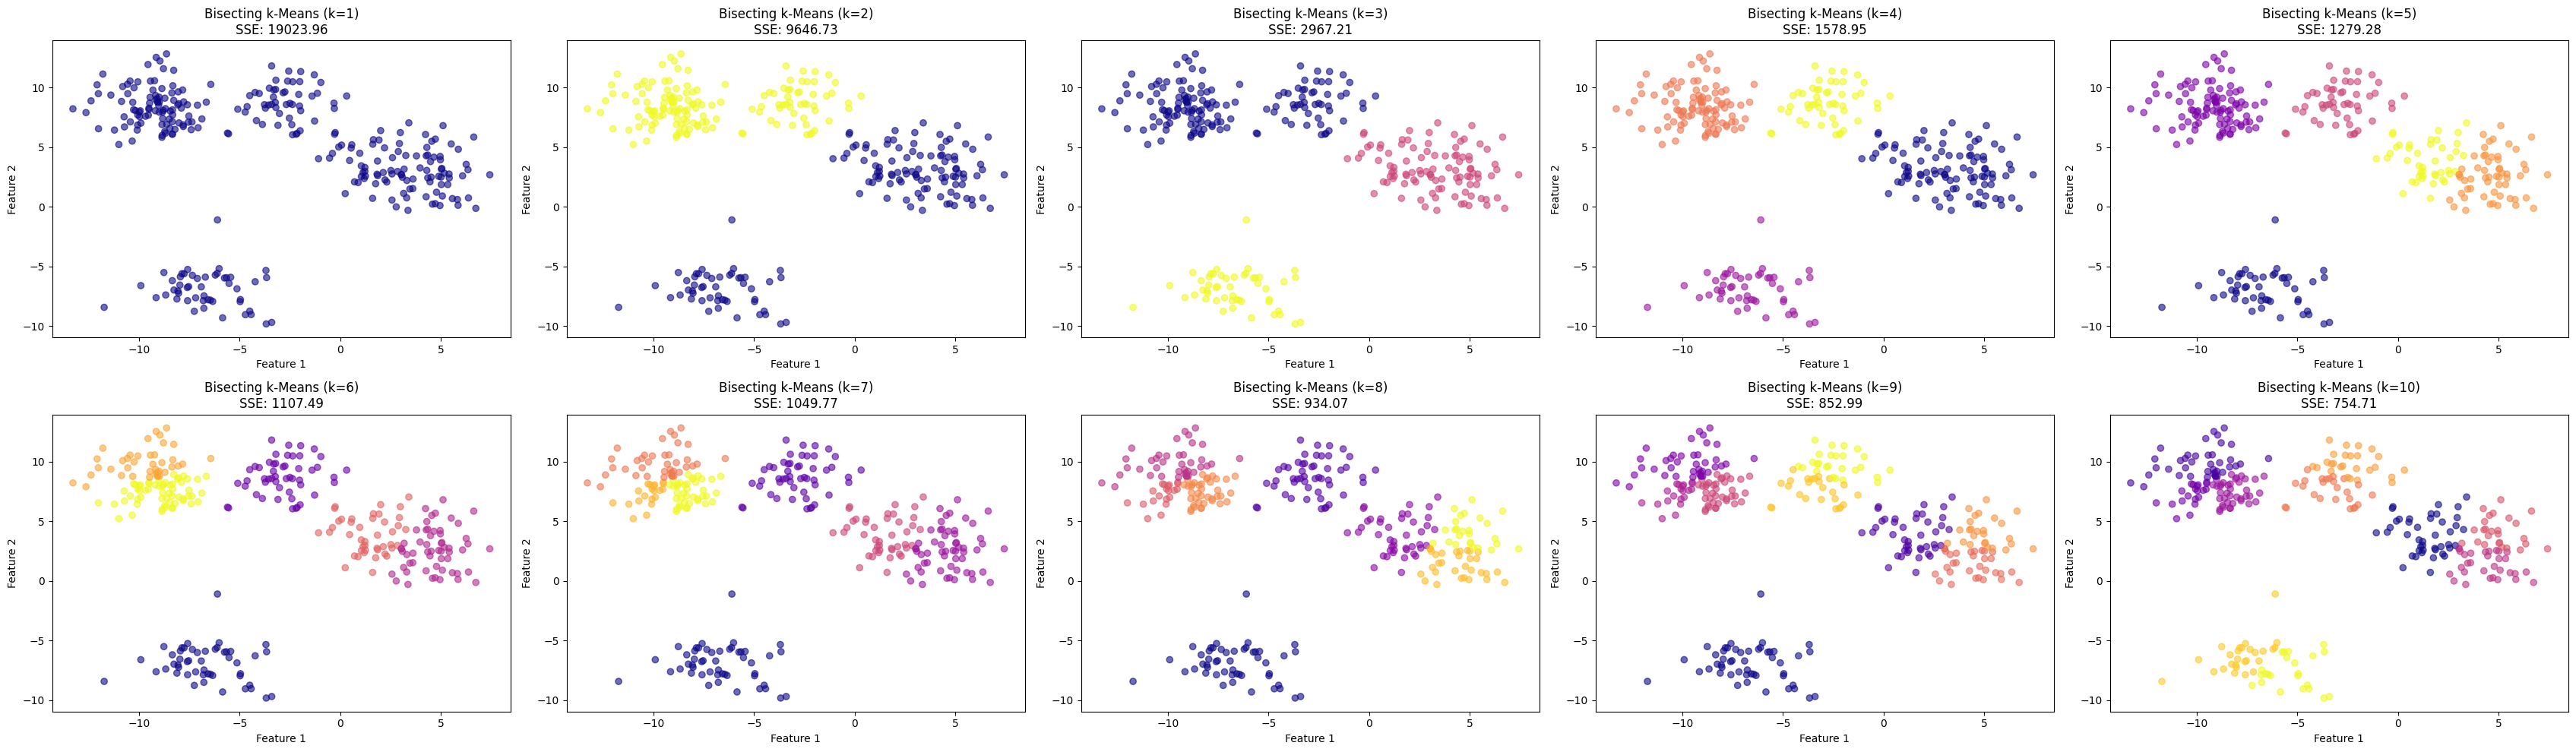


TESTING BISECTING K-MEANS WITH CAT DATASET

Cat dataset loaded successfully!
  - Number of samples: 1071
  - Number of features: 16
  - Features: ['Age_years', 'Body_length', 'Weight', 'Play_time', 'Sleep_time', 'Latitude', 'Longitude', 'Breed', 'Gender_male', 'Neutered', 'Outdoor_allowed', 'Food_wet', 'Fur_color', 'Fur_pattern', 'Eye_color', 'Country']

Testing different iteration values for k=4:

Testing iter=1:
  - Number of clusters found: 4
  - SSE: 12840.24
  - Cluster sizes: [np.int64(422), np.int64(199), np.int64(161), np.int64(289)]
  - Average cluster size: 267.8

Testing iter=5:
  - Number of clusters found: 4
  - SSE: 12056.15
  - Cluster sizes: [np.int64(251), np.int64(326), np.int64(303), np.int64(191)]
  - Average cluster size: 267.8

Testing iter=7:
  - Number of clusters found: 4
  - SSE: 12056.15
  - Cluster sizes: [np.int64(251), np.int64(326), np.int64(303), np.int64(191)]
  - Average cluster size: 267.8

Testing iter=10:
  - Number of clusters found: 4
  - SSE: 12

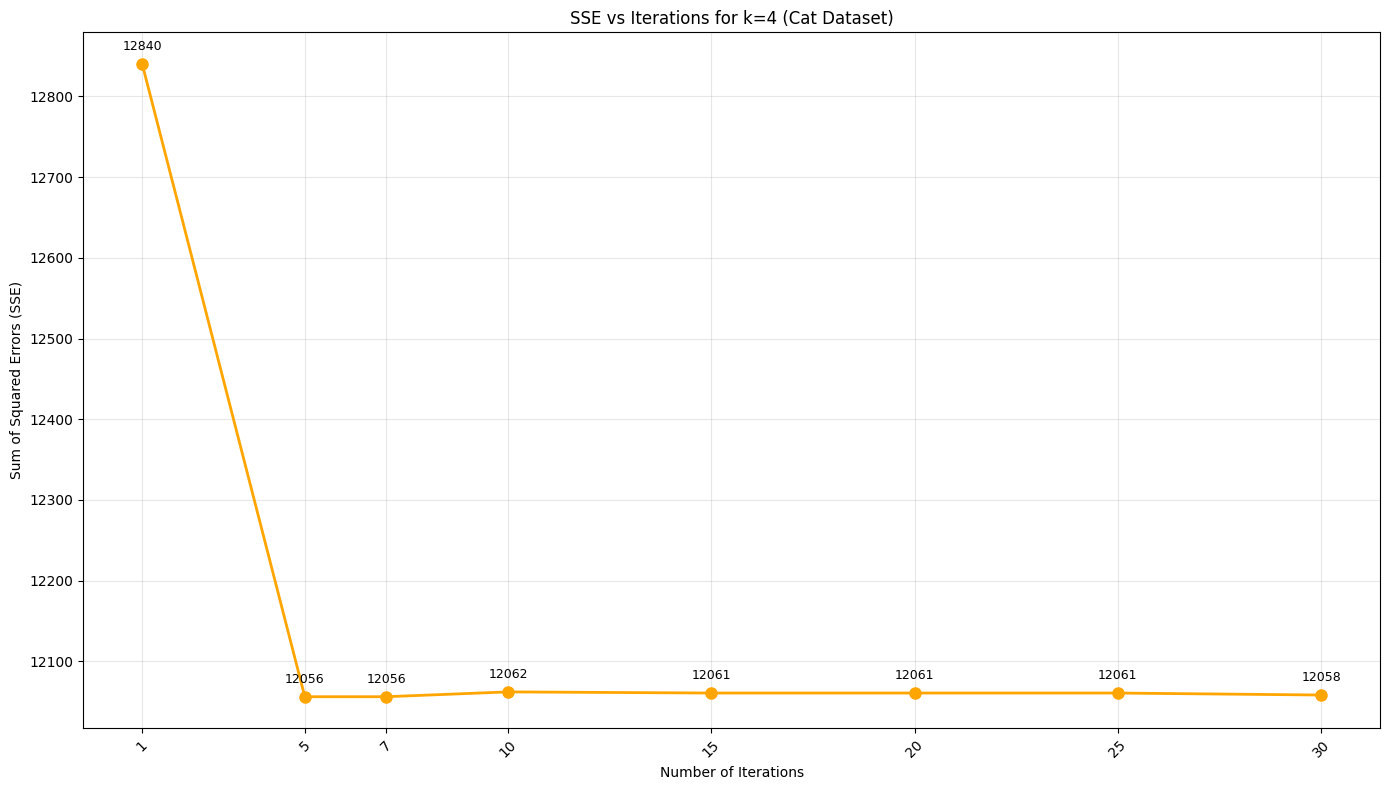


Best iteration value: 5 (SSE: 12056.15)

Detailed analysis for k=4, iter=5:


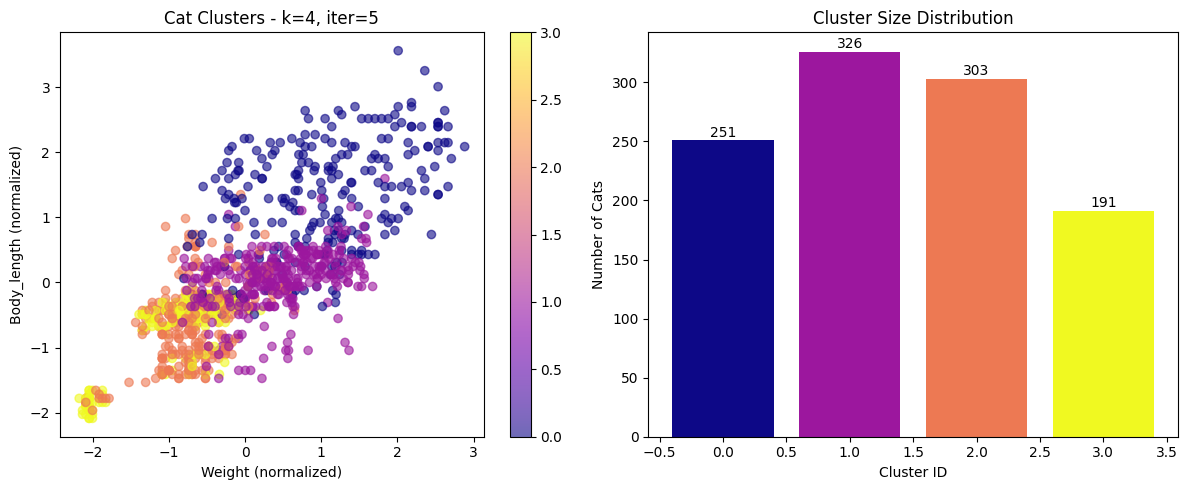


Convergence Analysis:
----------------------------------------
Iterations   SSE          Improvement    
----------------------------------------
1            12840.24     baseline       
5            12056.15     +784.09        
7            12056.15     +0.00          
10           12062.14     -5.99          
15           12060.71     +1.44          
20           12060.71     +0.00          
25           12060.71     +0.00          
30           12058.27     +2.44          


In [75]:
test_synthetic_data()
test_cat_data()

## Lecture 9 - Dimensionality Reduction 

### Task 1 (mandatory)

In this exercise you will visualize and explore the results of the previous exercise in a simple manner, using scatterplots.
This will be a relatively open-ended task; you will choose three data sets and explore them with the new technique you built for yourself. 

These could be data sets you already used in previous assignments, or you could download some
new data. The only restrictions are that (a) the data sets must be multidimensional (i.e., more than 4 features), (b) they must have labels, and (c) they must have at least 1000 data points.

These are some examples of interesting places to obtain new data sets:

* http://archive.ics.uci.edu/ml/index.php
* https://www.openml.org/search?type=data
* https://www.kaggle.com/datasets

Be careful, however, with the size of the data set you choose. Python can get quite slow with too much data, and the scatterplots will also be very crowded, so go for smaller data sets this time.

**Important**: Download the datasets and put them under the folder *datasets* so that we can run your code.

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import os

def pca(X, n_components=2):
    """
    Perform PCA dimensionality reduction using only numpy
    
    Args:
        X: Input data matrix (n_samples, n_features)
        n_components: Number of components to keep
    
    Returns:
        X_reduced: Transformed data (n_samples, n_components)
        explained_variance_ratio: Proportion of variance explained by each component
    """
    
    mean = np.mean(X, axis=0)
    X_centered = X - mean
    
    n_samples = X_centered.shape[0]
    cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)


    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    components = eigenvectors[:, :n_components]

    X_reduced = np.dot(X_centered, components)
    
    total_variance = np.sum(eigenvalues)
    explained_variance_ratio = eigenvalues[:n_components] / total_variance
    
    return X_reduced, explained_variance_ratio

In [77]:
def preprocess_cat_data(filepath):
    """
    Load and preprocess cat dataset
    Extracts numerical features and handles categorical variables
    """
    print(f"Loading cat data from {filepath}...")

    raw_data = np.genfromtxt(filepath, delimiter=';', dtype=None, encoding='utf-8', skip_header=1)
    
    print(f"Raw data shape: {raw_data.shape}")
    
    data = []
    labels = []
    
    for row in raw_data:
        try:
            breed = row[0].decode('utf-8') if isinstance(row[0], bytes) else str(row[0])
            
            age_months = float(row[2])  
            body_length = float(row[5]) 
            weight = float(row[6])  
            play_time = float(row[12])  
            sleep_time = float(row[13])  
            latitude = float(row[15]) 
            longitude = float(row[16]) 
            
            gender_str = row[3].decode('utf-8') if isinstance(row[3], bytes) else str(row[3])
            neutered_str = row[4].decode('utf-8') if isinstance(row[4], bytes) else str(row[4])
            outdoor_str = row[10].decode('utf-8') if isinstance(row[10], bytes) else str(row[10])
            
            gender_encoded = 1 if gender_str.lower() == 'male' else 0
            neutered_encoded = 1 if neutered_str.upper() == 'TRUE' else 0
            outdoor_encoded = 1 if outdoor_str.upper() == 'TRUE' else 0
            
            features = [age_months, body_length, weight, play_time, sleep_time, 
                       latitude, longitude, gender_encoded, neutered_encoded, outdoor_encoded]
            
            data.append(features)
            labels.append(breed)
            
        except (ValueError, IndexError) as e:
            print(f"Skipping row: {e}")
            continue
    
    print(f"Loaded {len(data)} cat samples with {len(data[0]) if data else 0} features")
    return np.array(data), np.array(labels)

def preprocess_yeast_data(filepath):
    """
    Load and preprocess yeast protein dataset
    """
    print(f"Loading yeast data from {filepath}...")
    
    raw_data = np.genfromtxt(filepath, delimiter=None, dtype=None, encoding='utf-8')
    
    print(f"Raw data shape: {raw_data.shape}")
    
    data = []
    labels = []
    
    for row in raw_data:
        if len(row) >= 10:
            try:
                features = [float(row[i]) for i in range(1, 9)]

                label = row[9].decode('utf-8') if isinstance(row[9], bytes) else str(row[9])
                
                data.append(features)
                labels.append(label)
                
            except (ValueError, IndexError) as e:
                print(f"Skipping row: {e}")
                continue
    
    print(f"Loaded {len(data)} yeast samples with {len(data[0]) if data else 0} features")
    return np.array(data), np.array(labels)

def preprocess_wine_data(filepath):
    """
    Load and preprocess wine quality dataset
    """
    print(f"Loading wine data from {filepath}...")
    
    raw_data = np.genfromtxt(filepath, delimiter=';', dtype=None, encoding='utf-8', skip_header=1)
    
    print(f"Raw data shape: {raw_data.shape}")
    
    data = []
    labels = []
    
    for row in raw_data:
        try:
            chemical_features = [float(row[i]) for i in range(len(row) - 1)]
            
            quality = int(row[-1])
            
            data.append(chemical_features)
            labels.append(quality)
            
        except (ValueError, IndexError) as e:
            print(f"Skipping row: {e}")
            continue
    
    print(f"Loaded {len(data)} wine samples with {len(data[0]) if data else 0} features")
    return np.array(data), np.array(labels)

In [78]:
def standardize_features(X):
    """
    Standardize features to have zero mean and unit variance
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std[std == 0] = 1
    return (X - mean) / std

def create_color_map(unique_labels):
    """Create a color map for unique labels"""
    n_colors = len(unique_labels)
    if n_colors <= 10:
        colors = plt.cm.tab10(np.linspace(0, 1, n_colors))
    else:
        colors = plt.cm.tab20(np.linspace(0, 1, min(n_colors, 20)))
    return dict(zip(unique_labels, colors))

def plot_2d_scatter(X_reduced, labels, title, ax):
    """
    Create 2D scatter plot with all data points
    """
    unique_labels = np.unique(labels)
    color_map = create_color_map(unique_labels)
    
    for label in unique_labels:
        mask = labels == label
        ax.scatter(X_reduced[mask, 0], X_reduced[mask, 1], 
                  c=[color_map[label]], label=str(label), alpha=0.7, s=10)
    
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title(title)

    if len(unique_labels) <= 10:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.text(0.02, 0.98, f'{len(unique_labels)} classes', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.grid(True, alpha=0.3)

In [79]:
def analyze_dataset(data_path, dataset_name, preprocess_function):
    """
    Analyze a single dataset with PCA
    """
    print(f"\n=== Analyzing {dataset_name} Dataset ===")
    
    try:
        X, y = preprocess_function(data_path)
        
        if len(X) == 0:
            print(f"No valid data found in {data_path}")
            return None
        
        print(f"Dataset shape: {X.shape}")
        print(f"Number of unique labels: {len(np.unique(y))}")
        print(f"Sample labels: {np.unique(y)[:10]}...") 

        if X.shape[0] < 1000:
            print(f"Warning: Dataset has {X.shape[0]} samples (requirement: ≥1000)")
        if X.shape[1] <= 4:
            print(f"Warning: Dataset has {X.shape[1]} features (requirement: >4)")

        X_std = standardize_features(X)

        X_reduced, explained_variance_ratio = pca(X_std, n_components=2)
        
        print(f"Explained variance ratio: PC1={explained_variance_ratio[0]:.3f}, PC2={explained_variance_ratio[1]:.3f}")
        print(f"Total explained variance: {np.sum(explained_variance_ratio):.3f}")
        
        return X_reduced, y, explained_variance_ratio, X.shape
        
    except Exception as e:
        print(f"Error processing {dataset_name}: {str(e)}")
        return None

=== Dimensionality Reduction Analysis ===

=== Analyzing Cat Breeds Dataset ===
Loading cat data from datasets\your_datasets\cat_breeds_clean.csv...
Raw data shape: (1071,)
Loaded 1071 cat samples with 10 features
Dataset shape: (1071, 10)
Number of unique labels: 3
Sample labels: ['Angora' 'Maine coon' 'Ragdoll']...
Explained variance ratio: PC1=0.265, PC2=0.152
Total explained variance: 0.417

=== Analyzing Yeast Proteins Dataset ===
Loading yeast data from datasets\your_datasets\yeast.data...
Raw data shape: (1484,)
Loaded 1484 yeast samples with 8 features
Dataset shape: (1484, 8)
Number of unique labels: 10
Sample labels: ['CYT' 'ERL' 'EXC' 'ME1' 'ME2' 'ME3' 'MIT' 'NUC' 'POX' 'VAC']...
Explained variance ratio: PC1=0.227, PC2=0.159
Total explained variance: 0.386

=== Analyzing Wine Quality Dataset ===
Loading wine data from datasets\your_datasets\winequality-red.csv...
Raw data shape: (1599,)
Loaded 1599 wine samples with 11 features
Dataset shape: (1599, 11)
Number of unique lab

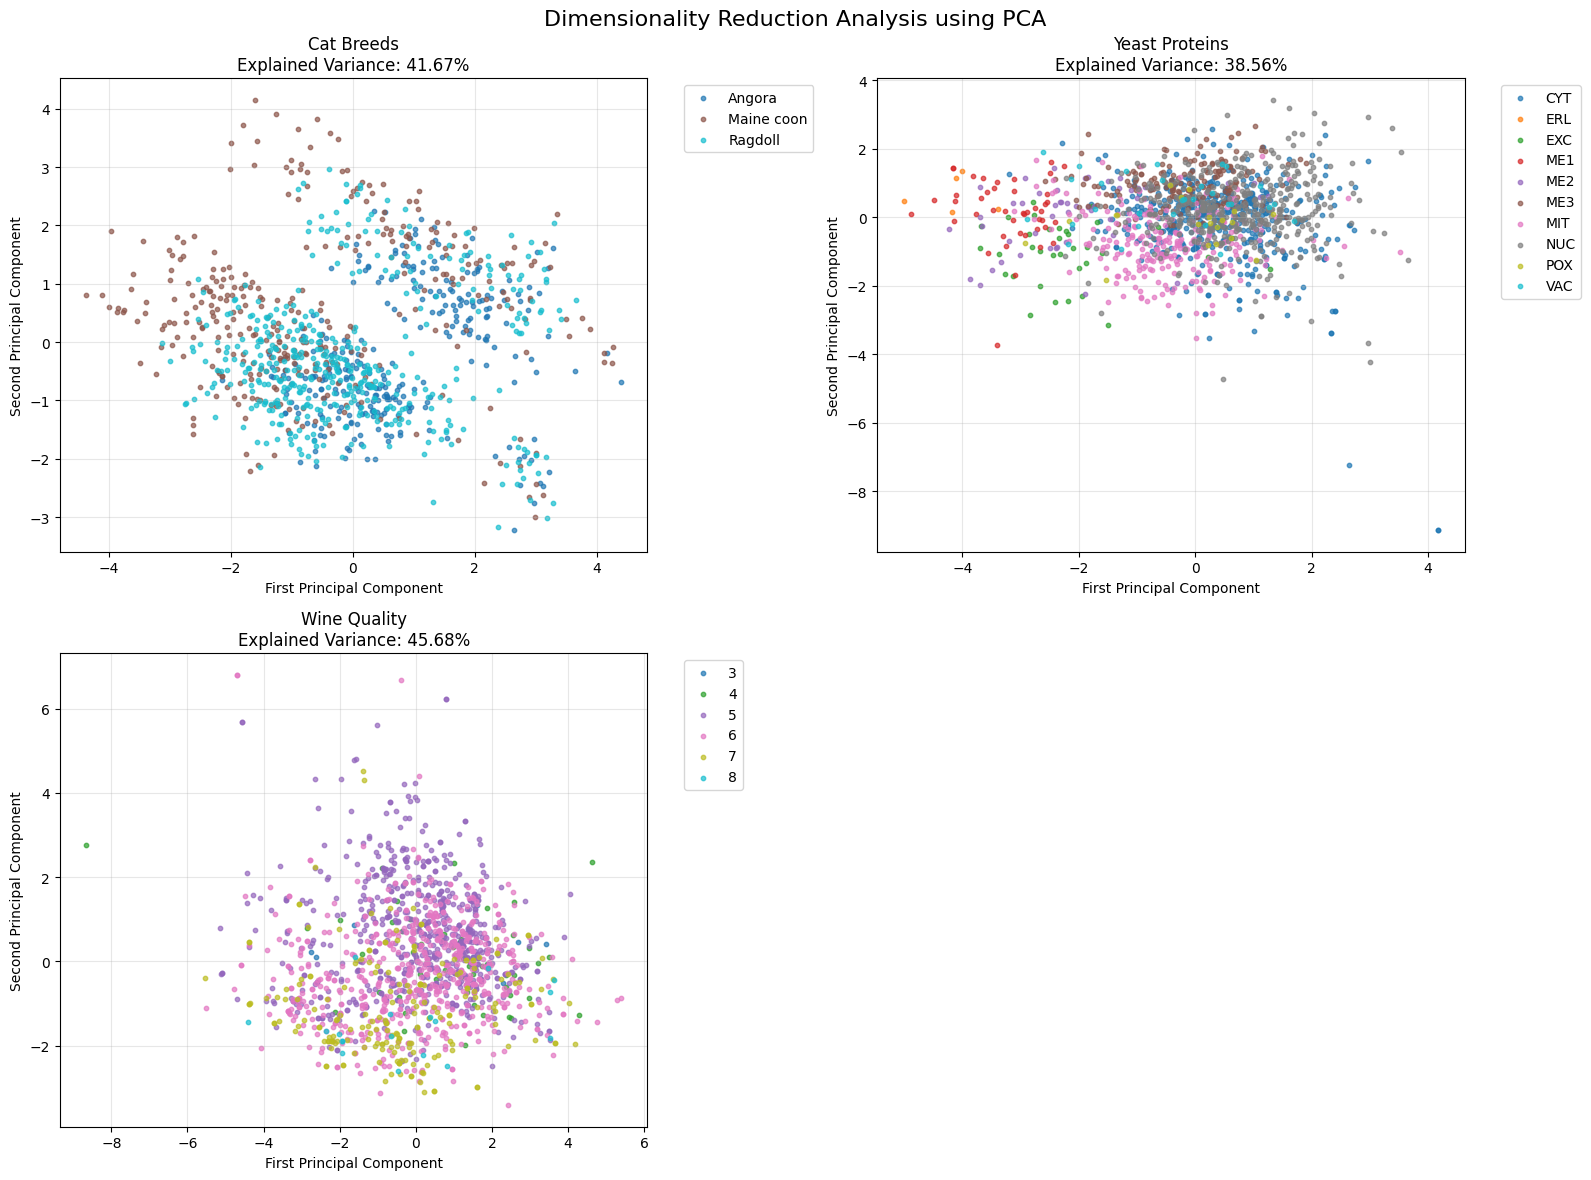


SUMMARY STATISTICS

Cat Breeds:
  Original dimensions: (1071, 10)
  Samples: 1,071
  Features: 10
  Classes: 3
  PC1 explained variance: 26.5%
  PC2 explained variance: 15.2%
  Total variance captured: 41.7%
  PC1 range: 8.76
  PC2 range: 7.38

Yeast Proteins:
  Original dimensions: (1484, 8)
  Samples: 1,484
  Features: 8
  Classes: 10
  PC1 explained variance: 22.7%
  PC2 explained variance: 15.9%
  Total variance captured: 38.6%
  PC1 range: 9.18
  PC2 range: 12.56

Wine Quality:
  Original dimensions: (1599, 11)
  Samples: 1,599
  Features: 11
  Classes: 6
  PC1 explained variance: 28.2%
  PC2 explained variance: 17.5%
  Total variance captured: 45.7%
  PC1 range: 14.04
  PC2 range: 10.23


In [80]:
np.random.seed(865)

print("=== Dimensionality Reduction Analysis ===")
    
datasets = [
    ('datasets\your_datasets\cat_breeds_clean.csv', 'Cat Breeds', preprocess_cat_data),
    ('datasets\your_datasets\yeast.data', 'Yeast Proteins', preprocess_yeast_data),
    ('datasets\your_datasets\winequality-red.csv', 'Wine Quality', preprocess_wine_data)
]

results = []

for data_path, dataset_name, preprocess_func in datasets:
    if os.path.exists(data_path):
        result = analyze_dataset(data_path, dataset_name, preprocess_func)
        if result is not None:
            results.append((result, dataset_name))
    else:
        print(f"Dataset not found: {data_path}")

if results:
    n_datasets = len(results)
    if n_datasets == 1:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        axes = [ax]
    elif n_datasets == 2:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()

    fig.suptitle('Dimensionality Reduction Analysis using PCA', fontsize=16)

    for i, ((X_reduced, labels, explained_var, original_shape), dataset_name) in enumerate(results):
        if i < len(axes):
            plot_title = f'{dataset_name}\nExplained Variance: {np.sum(explained_var):.2%}'
            plot_2d_scatter(X_reduced, labels, plot_title, axes[i])

    for i in range(len(results), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)

    for (X_reduced, labels, explained_var, original_shape), dataset_name in results:
        unique_labels = np.unique(labels)
        print(f"\n{dataset_name}:")
        print(f"  Original dimensions: {original_shape}")
        print(f"  Samples: {len(X_reduced):,}")
        print(f"  Features: {original_shape[1]}")
        print(f"  Classes: {len(unique_labels)}")
        print(f"  PC1 explained variance: {explained_var[0]:.1%}")
        print(f"  PC2 explained variance: {explained_var[1]:.1%}")
        print(f"  Total variance captured: {np.sum(explained_var):.1%}")
        
        pc1_range = np.ptp(X_reduced[:, 0])
        pc2_range = np.ptp(X_reduced[:, 1])
        print(f"  PC1 range: {pc1_range:.2f}")
        print(f"  PC2 range: {pc2_range:.2f}")
else:
    print("No datasets could be loaded. Please check your dataset files.")

### Task 2 (non-mandatory) - Comparison of DR Techniques

Generate a scatterplot matrix comparing the results of three DR techniques: PCA, MDS, and t-SNE, for each data set chosen in the previous exercise. 
The resulting visualization should be a 3 × 3 matrix where each cell is a scatterplot of a DR technique applied to a data set. 
Color the points by their target variables (i.e., class/labels) using a qualitative colormap.

Then answer this shortly (in a couple of paragraphs): 
- In your opinion, which technique performed the best for each data set, regarding the separation of the classes? 
- How are the classes in the data sets separated? 
- Are some classes easier to separate than others?


---

For the MDS, I tried to implement the Sammon Stress discussed in the lecture.

For t-SNE after looking at different sources, I used [this](https://towardsdatascience.com/understanding-t-sne-by-implementing-2baf3a987ab3/#:~:text=Introduction,data%20as%20much%20as%20possible.) as a reference while writing the code.

For visualization purposes only 300 samples were used, since my computer could not handle more than that, and I had runtimes that were over an hour and still didn't produce results. It is possible to run these for the full datasets.

---

**Which technique performed best for each dataset:**

For the Cat Breeds dataset, t-SNE clearly performs the best. While PCA and MDS show overlapping clusters with minimal separation between the different cat breeds, t-SNE creates distinct, well-separated clusters where each breed forms its own compact group with clear boundaries between them.

For the Yeast Proteins dataset, t-SNE again demonstrates superior performance. PCA and MDS show significant overlap between the different protein localization classes, making it difficult to distinguish between classes. t-SNE successfully separates most classes into distinct clusters, though some overlap still exists between certain classes.

For the Wine Quality dataset, the results are more complicated. All three techniques show considerable overlap, which reflects the inherent difficulty in separating wine quality ratings (3-8) based on chemical properties. However, t-SNE still provides the clearest structure, showing some grouping patterns that are less apparent in PCA and MDS.

**How classes are separated:**

t-SNE's better performance comes from its ability to preserve local neighborhood structure while creating global separation between different classes. It forms tight, compact clusters for each class while maximizing the distance between different classes. In contrast, PCA and MDS tend to create more linear or globally-structured embeddings that often result in overlapping class boundaries.

Some classes are indeed easier to separate than others. In the yeast dataset, certain protein localization sites form very distinct clusters (visible as isolated groups in t-SNE), while others remain mixed. Similarly, in the wine quality dataset, extreme quality ratings (very low or very high) tend to be more separable than middle-range qualities, reflecting the continuous nature of the quality scale rather than discrete categories.


In [81]:
import numpy as np
import matplotlib.pyplot as plt

def euclidean_distance(X):
    """
    Compute pairwise Euclidean distances
    """
    n = X.shape[0]
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.sqrt(np.sum((X[i] - X[j])**2))
            distances[i, j] = dist
            distances[j, i] = dist
    return distances

def mds(X, n_components=2, max_iter=50, learning_rate=0.01):
    """
    Perform Multidimensional Scaling (MDS) using gradient descent
    """
    n_samples = X.shape[0]

    delta = euclidean_distance(X)
    delta_safe = np.where(delta == 0, 1e-8, delta)  

    Y, _ = pca(X, n_components)

    c = np.sum(delta) / 2

    for iteration in range(max_iter):
        dist = euclidean_distance(Y)

        dist_safe= np.where(dist == 0, 1e-8, dist)

        stress = 0.0

        for i in range(n_samples):
            for j in range(i+1, n_samples):
                if delta[i, j] > 0:
                    stress += (delta[i, j] - dist[i, j])**2 / delta_safe[i, j]
        stress /= c

        if iteration % 50 == 0:
            if stress < 1e-6:
                break          

        grad = np.zeros_like(Y)
        for i in range(n_samples):
            grad_i = np.zeros(n_components)
            for j in range(n_samples):
                if i != j:
                    diff = Y[i] - Y[j]
                    factor = (delta[i, j] - dist[i, j]) / (delta_safe[i, j] * dist_safe[i, j])
                    grad_i += factor * diff
            grad[i] = grad_i
        grad *= (-2 / c)
        Y -= learning_rate * grad
    return Y



In [82]:
def compute_sigma_for_perplexity(distances_row, target_perplexity=30.0, tolerance=1e-10, max_iter=1000):
    """
    Binary search to find the right sigma for a given perplexity
    """
    low_bound, upp_bound = 1e-20, 10000
    sigma = (upp_bound + low_bound) / 2.0
    for _ in range(max_iter):
        sigma = (upp_bound + low_bound) / 2.0
        
        # Compute conditional probabilities using Gaussian
        probs = np.exp(-distances_row / (2 * sigma**2))
        probs += 1e-8 
        probs = probs / np.sum(probs)
        
        entropy = -np.sum(probs * np.log2(probs))
        perplexity = 2 ** entropy
        
        if abs(perplexity - target_perplexity) <= tolerance:
            return sigma
        
        if perplexity > target_perplexity:
            upp_bound = sigma
        else:
            low_bound = sigma
    
    
    return sigma

def tsne(X, n_components=2, perplexity=30, max_iter=100, learning_rate=200.):
    n_samples = X.shape[0]
    distances_sq = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            if i != j:
                distances_sq[i, j] = np.sum((X[i] - X[j])**2)

    sigmas = np.zeros(n_samples)
    for i in range(n_samples):
        dist_row = distances_sq[i].copy()
        dist_row[i] = np.inf
        sigmas[i] = compute_sigma_for_perplexity(dist_row, perplexity)

    P_cond = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        sigma = sigmas[i]
        probs = np.exp(-distances_sq[i] / (2 * sigma**2))
        probs[i] = 0  
        probs += 1e-8
        P_cond[i] = probs / np.sum(probs)

    P = (P_cond + P_cond.T) / (2 * n_samples)
    P = np.maximum(P, 1e-12)
    
    np.random.seed(865)
    Y = np.random.normal(0, 1e-4, (n_samples, n_components))
    Y_prev = Y.copy()
    
    for iteration in range(max_iter):
        sum_Y = np.sum(Y**2, axis=1)
        distances_Y = sum_Y[:, None] + sum_Y[None, :] - 2 * np.dot(Y, Y.T)
        Q_num = 1 / (1 + distances_Y)
        np.fill_diagonal(Q_num, 0)
        Q = Q_num / np.sum(Q_num)
        Q = np.maximum(Q, 1e-12)
        
        PQ_diff = P - Q
        gradient = np.zeros_like(Y)
        
        Y_diff = Y[:, None, :] - Y[None, :, :] 
        grad_factor = (PQ_diff[:, :, None] * Q_num[:, :, None] * Y_diff)
        gradient = 4 * np.sum(grad_factor, axis=1)
        
        momentum_factor = 0.5 if iteration < 250 else 0.8
        Y_new = Y - learning_rate * gradient + momentum_factor * (Y - Y_prev)

        Y_prev = Y.copy()
        Y = Y_new
            
    return Y
  

In [83]:
def compare_dr_techniques(datasets, dataset_names, preprocess_functions):
    """
    Compare PCA, MDS, and t-SNE on multiple datasets
    Creates a 3×n matrix visualization where n is the number of datasets
    """
    n_datasets = len(datasets)
    
    fig, axes = plt.subplots(n_datasets, 3, figsize=(18, 6*n_datasets))
    if n_datasets == 1:
        axes = axes.reshape(1, -1)
    
    for i, (dataset_path, dataset_name, preprocess_func) in enumerate(zip(datasets, dataset_names, preprocess_functions)):
        print(f"\n{'='*50}")
        print(f"Processing {dataset_name}")
        print('='*50)
        
        X, y = preprocess_func(dataset_path)

        if len(X) > 300:
            print(f"Dataset has {len(X)} samples. Limiting to 300 for visualization...")
            np.random.seed(865)  
            indices = np.random.choice(len(X), 300, replace=False)
            X = X[indices]
            y = y[indices]
        
        print(f"Final dataset shape: {X.shape}")
        print(f"Number of classes: {len(np.unique(y))}")
        print(f"Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
        
        X_std = standardize_features(X)
        
        print("\nPCA...")
        X_pca, explained_var = pca(X_std, n_components=2)
        plot_2d_scatter(X_pca, y, f'PCA - {dataset_name}\n(Var: {explained_var[0]:.2f}, {explained_var[1]:.2f})', axes[i, 0])
        
        print("MDS...")
        X_mds = mds(X_std, n_components=2)
        plot_2d_scatter(X_mds, y, f'MDS - {dataset_name}', axes[i, 1])
        
        print("t-SNE...")
        perplexity_val = min(30, len(X)//4)
        X_tsne = tsne(X_std, n_components=2, perplexity=perplexity_val, 
                        learning_rate=200, max_iter=100)
        plot_2d_scatter(X_tsne, y, f't-SNE - {dataset_name}\n(perplexity={perplexity_val})', axes[i, 2])
        
    
    plt.tight_layout()
    plt.show()

Starting Dimensionality Reduction Comparison...
This will create a 3×3 matrix comparing PCA, MDS, and t-SNE

Processing Cat Breeds
Loading cat data from datasets\your_datasets\cat_breeds_clean.csv...
Raw data shape: (1071,)
Loaded 1071 cat samples with 10 features
Dataset has 1071 samples. Limiting to 300 for visualization...
Final dataset shape: (300, 10)
Number of classes: 3
Class distribution: {np.str_('Angora'): np.int64(83), np.str_('Maine coon'): np.int64(91), np.str_('Ragdoll'): np.int64(126)}

PCA...
MDS...
t-SNE...

Processing Yeast Proteins
Loading yeast data from datasets\your_datasets\yeast.data...
Raw data shape: (1484,)
Loaded 1484 yeast samples with 8 features
Dataset has 1484 samples. Limiting to 300 for visualization...
Final dataset shape: (300, 8)
Number of classes: 9
Class distribution: {np.str_('CYT'): np.int64(101), np.str_('EXC'): np.int64(5), np.str_('ME1'): np.int64(10), np.str_('ME2'): np.int64(11), np.str_('ME3'): np.int64(35), np.str_('MIT'): np.int64(42), n

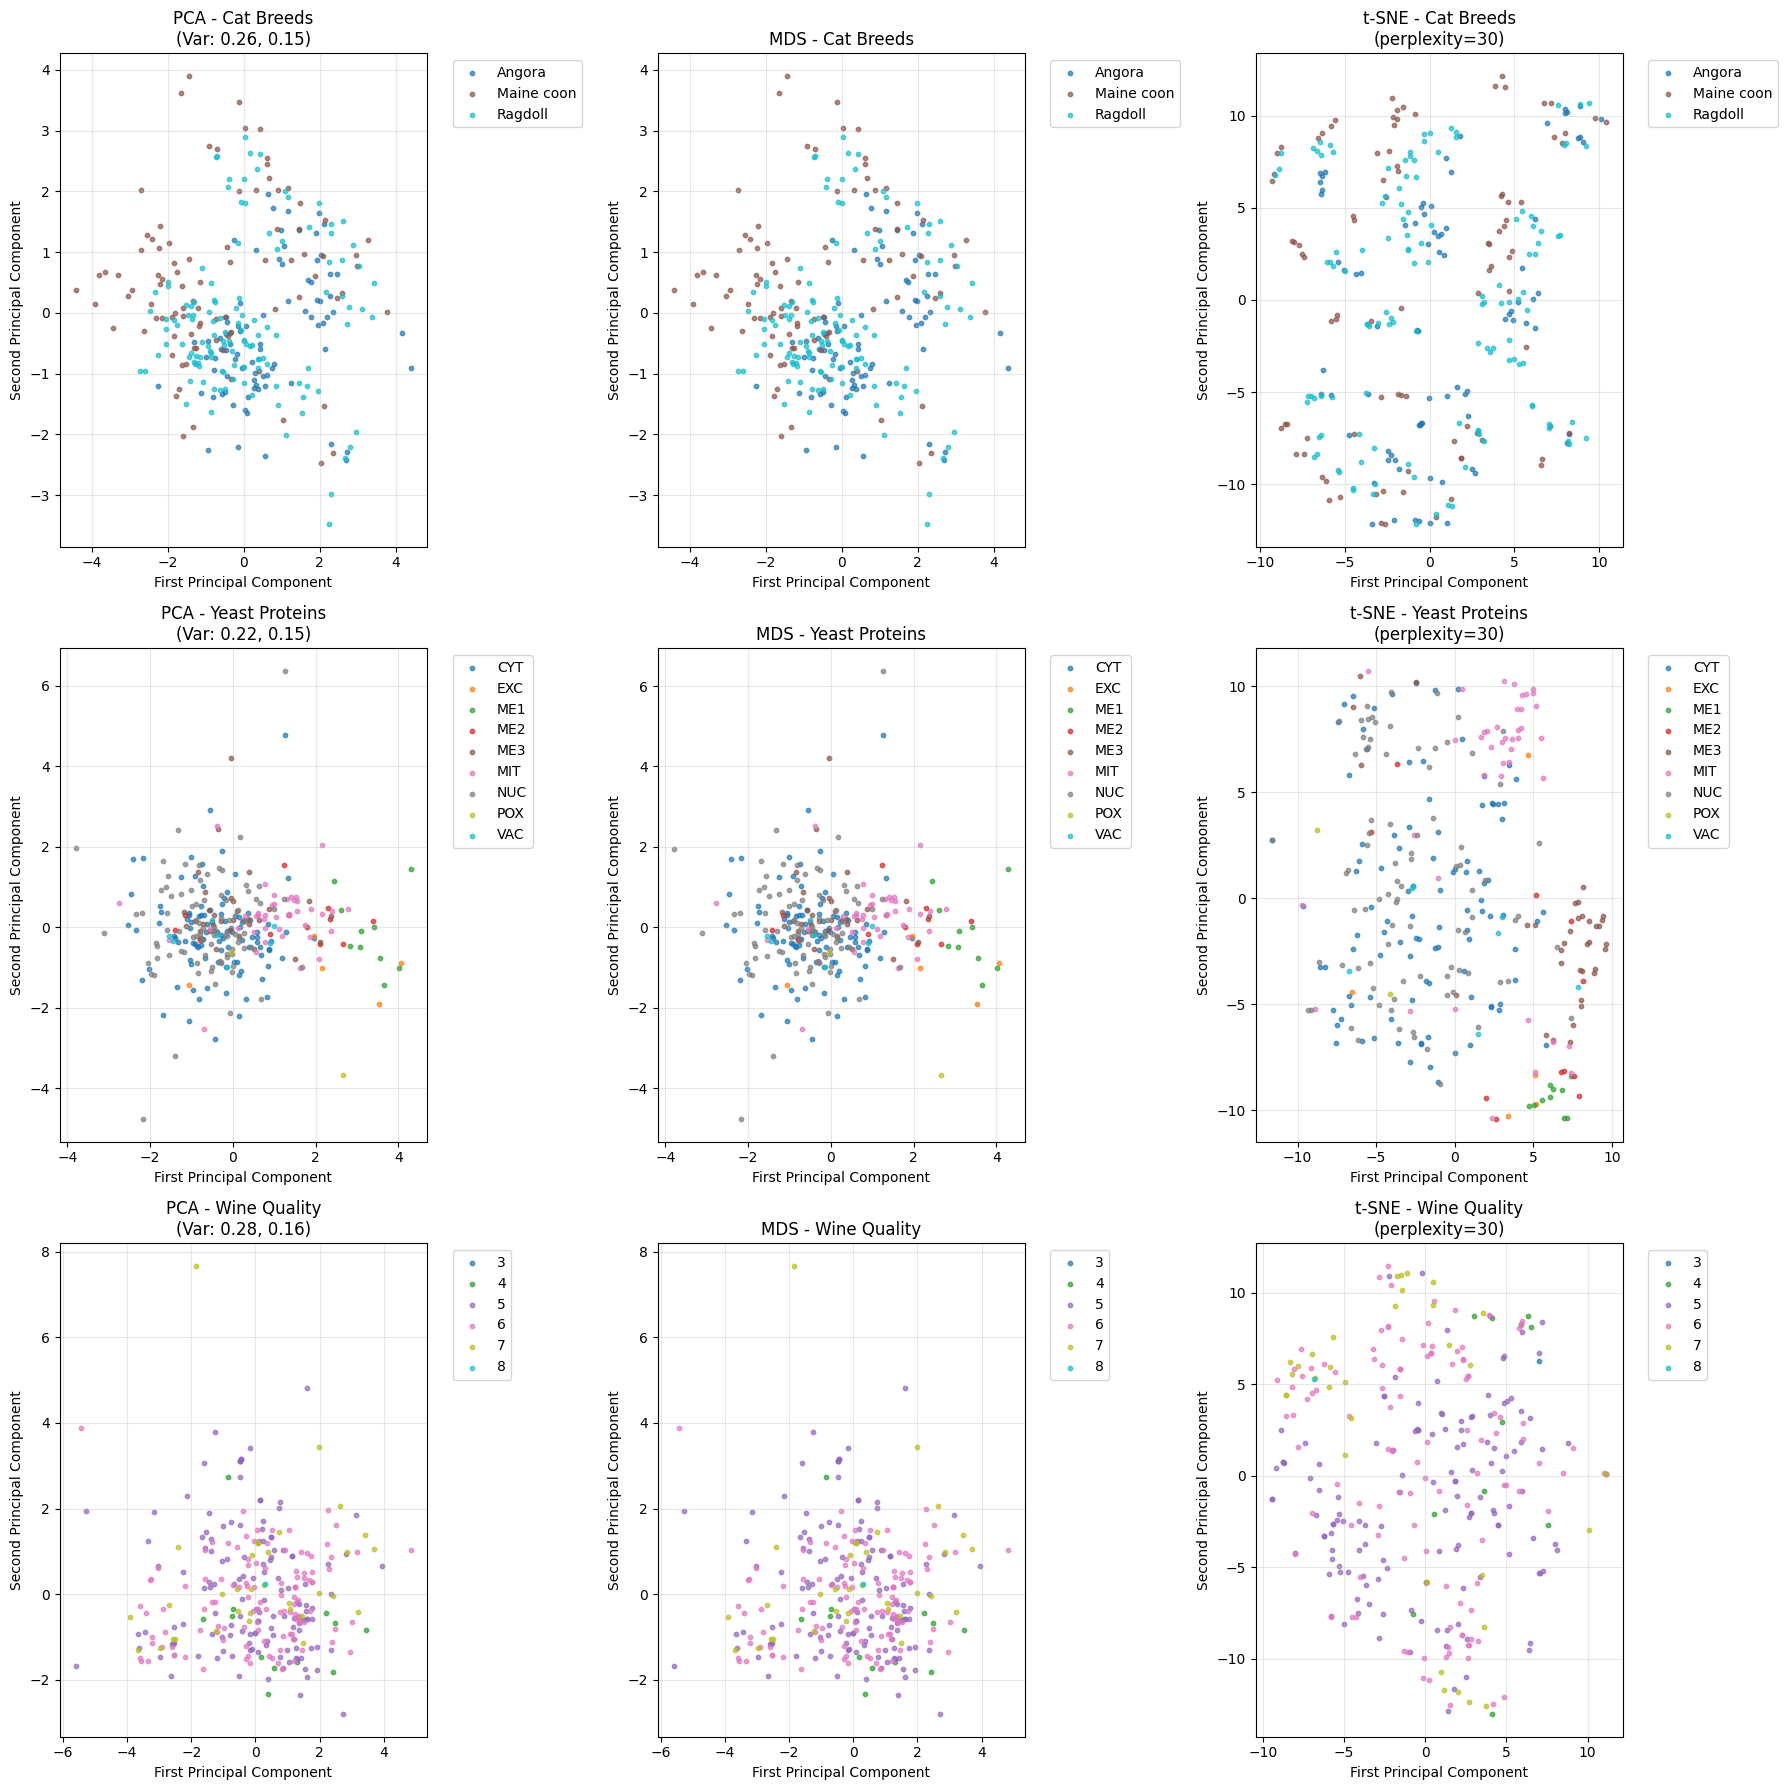

In [84]:
datasets = [
    'datasets\your_datasets\cat_breeds_clean.csv', 
    'datasets\your_datasets\yeast.data', 
    'datasets\your_datasets\winequality-red.csv'
]

dataset_names = ["Cat Breeds", "Yeast Proteins", "Wine Quality"]

preprocess_functions = [preprocess_cat_data, preprocess_yeast_data, preprocess_wine_data]


print("Starting Dimensionality Reduction Comparison...")
print("This will create a 3×3 matrix comparing PCA, MDS, and t-SNE")

compare_dr_techniques(datasets, dataset_names, preprocess_functions)

### Task 3 (non-mandatory): Comparison of Clustering Techniques

Choose one of the DR techniques from the previous exercise and generate a similar scatterplot matrix to compare the results of Bisecting k-Means with classic k-Means and hierarchical clustering for each data set. 
The resulting visualization should be a 3 × 3 matrix where each cell is a scatterplot of the chosen DR technique applied to a data set, with the colors of the points showing the clusters using a qualitative colormap (see, e.g., https://matplotlib.org/tutorials/colors/colormaps.html).

Then answer this shortly (in a couple of paragraphs): 
- In your opinion, which clustering technique performed the best for each data set? 
- How are the clusters in the data sets separated? 
- Are some clusters easier to separate than others?